### Data Exploration and Understanding
1. Dataset statistics 
  * How many instances of solar panels are present in the dataset?
  * Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

2. Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)
 * What method was used to compute the area (in meters) for a single instance?
 * What is the mean area and standard deviation?
 * Plot the histogram of areas. What do you observe?


In [30]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random

In [31]:
#load data
images_data = "/Users/sohamshrivastava/Desktop/untitled_folder/image_chips_native"
labels_data = "/Users/sohamshrivastava/Desktop/untitled_folder/labels/labels_native"


In [32]:
images = []
labels =[]

for file_name in os.listdir(images_data):
    if file_name.endswith("tif"):
        file_path = os.path.join(images_data, file_name)
        images.append(file_path)
        
images = sorted(images)

for file_name in os.listdir(labels_data):
    if file_name.endswith("txt"):
        file_path = os.path.join(labels_data, file_name)
        labels.append(file_path)

labels = sorted(labels)
print(f'length of labels {len(labels)}')
print(f'length of images {len(images)}')        

length of labels 2542
length of images 2553


In [33]:
#since images and labels are not equal so we have to remove those images which do not have labels

valid_images = []
for image_name in os.listdir(images_data):
    if image_name.endswith(".tif"): 
        label_name = os.path.splitext(image_name)[0] + ".txt" # replace name with txt and then check if in labels it exists or not 
        label_path = os.path.join(labels_data, label_name)
        
        if os.path.exists(label_path):
            image_path = os.path.join(images_data, image_name)
            valid_images.append(image_path)

print(f"Total valid images with labels: {len(valid_images)}")

valid_images = sorted(valid_images)   

Total valid images with labels: 2542


In [34]:
# Now we will check total instances of solar panels present in dataset 
total_panels = 0
for label_path in labels:
    with open(label_path, "r") as file:
        lines = file.readlines()
        total_panels += len(lines)
print(f"Total number of solar panels in the dataset: {total_panels}")

Total number of solar panels in the dataset: 29625


In [35]:
# now we will compute value counts of labels per image 
labels_per_image = {}

for image_name in os.listdir(images_data):
    if image_name.endswith(".tif"):  
        
        label_name = os.path.splitext(image_name)[0] + ".txt" 
        label_path = os.path.join(labels_data, label_name)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                num_labels = len(f.readlines())
        else:     
            num_labels = 0
        if num_labels in labels_per_image:
            labels_per_image[num_labels] += 1
        else:
            labels_per_image[num_labels] = 1


labels_per_image_df = pd.DataFrame(list(labels_per_image.items()), columns=["Number of Labels", "Number of Images"])
labels_per_image_df = labels_per_image_df.sort_values(by="Number of Labels")  # Sort by number of labels
labels_per_image_df = labels_per_image_df.reset_index(drop=True)

# Print the result
labels_per_image_df

,Number of Labels,Number of Images
0,0,11
1,1,81
2,2,167
3,3,221
4,4,218
...,...,...
70,74,5
71,75,1
72,76,2
73,77,2


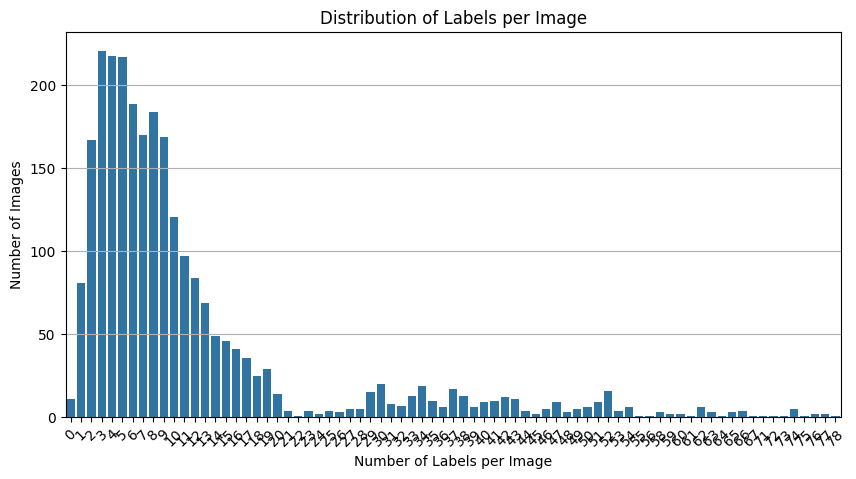

In [36]:
plt.figure(figsize=(10, 5))
sns.barplot(x=labels_per_image_df["Number of Labels"], y=labels_per_image_df["Number of Images"])

plt.xlabel("Number of Labels per Image")
plt.ylabel("Number of Images")
plt.title("Distribution of Labels per Image")
plt.xticks(rotation=45) 
plt.grid(axis='y')
plt.show()


In [38]:
resolution = 0.31 
areas = []

for label_file in labels:
    with open(label_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            i, x_center, y_center, width, height = map(float, line.strip().split())
            width_meters = width * resolution
            height_meters = height * resolution

            area = width_meters * height_meters
            areas.append(area)

areas = np.array(areas)
# mean_area = np.mean(areas)
# std_area = np.std(areas)

print(f"Mean area of solar panels: {np.mean(areas):.5f} m^2")
print(f"Standard deviation of areas: {np.std(areas):.5f} m^2")

Mean area of solar panels: 0.00111 m^2
Standard deviation of areas: 0.00364 m^2


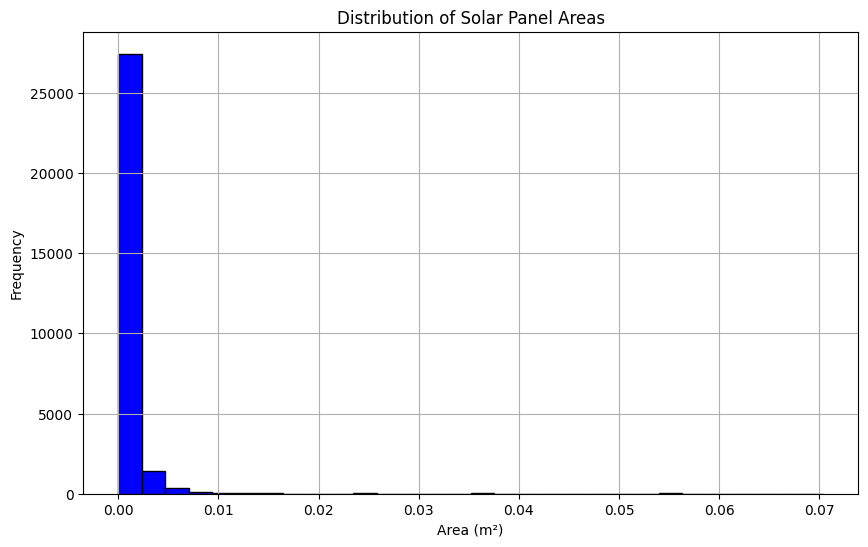

In [39]:
# plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=30, color="blue", edgecolor="black")
plt.title("Distribution of Solar Panel Areas")
plt.xlabel("Area (m²)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We can see the areas of solar panels are very less which means all the photos contains very less amount of solars like solars we have in our local areas in town and streets, not any kind of solar park.

2. Implementing the Fundamental Functions
   * Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library 


   * Write a function to compute Average Precision (AP) 
      * Use Pascal VOC 11 point interpolation method to implement the function 
      * Use COCO 101-point interpolation method to implement the function
      * Use Area under Precision-Recall Curve (AP) method to implement the function 
      * Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods
      


In [ ]:
# first we will convert the yolo format to coordinates
def coords(x_center, y_center, width, height, image_width=416, image_height=416):
    
    x_min = (x_center - width / 2) * image_width
    y_min = (y_center - height / 2) * image_height
    x_max = (x_center + width / 2) * image_width
    y_max = (y_center + height / 2) * image_height
    return np.array([x_min, y_min, x_max, y_max])

# defining IoU function from scratch
def IoU(grnd_box, pred_box, image_width=416, image_height=416):
    
    grnd = coords(*grnd_box, image_width, image_height)
    pred = coords(*pred_box, image_width, image_height)

    xA = max(grnd[0], pred[0])
    yA = max(grnd[1], pred[1])
    xB = min(grnd[2], pred[2])
    yB = min(grnd[3], pred[3])
    
    
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    grnd_area = (grnd[2] - grnd[0]) * (grnd[3] - grnd[1])
    pred_area = (pred[2] - pred[0]) * (pred[3] - pred[1])
    iou = inter_area / (grnd_area + pred_area - inter_area)
    return iou




In [ ]:
from shapely.geometry import Polygon

def iou_shapely(gt_box, pred_box, image_width=416, image_height=416):
    # YOLO format to coordinates
    gt_coords = coords(*gt_box, image_width, image_height)
    pred_coords = coords(*pred_box, image_width, image_height)
    
    # polygon objects for creating bounding boxes 
    gt_polygon = Polygon([(gt_coords[0], gt_coords[1]), (gt_coords[2], gt_coords[1]), 
                          (gt_coords[2], gt_coords[3]), (gt_coords[0], gt_coords[3])])
    pred_polygon = Polygon([(pred_coords[0], pred_coords[1]), (pred_coords[2], pred_coords[1]), 
                           (pred_coords[2], pred_coords[3]), (pred_coords[0], pred_coords[3])])
    
    intersection = gt_polygon.intersection(pred_polygon).area
    union = gt_polygon.union(pred_polygon).area
    
    # compute IOU
    if union!=0:
        iou = intersection / union 
    else:    
        return iou


In [215]:
import supervision as sv
from supervision.detection.utils import box_iou_batch

def compute_iou_supervision(gt_box, pred_box, image_width=416, image_height=416):
    # YOLO format to coordinates
    gt_coords = coords(*gt_box, image_width, image_height).reshape(1, 4)
    pred_coords = coords(*pred_box, image_width, image_height).reshape(1, 4)
    
    # compute IoU
    iou = box_iou_batch(gt_coords, pred_coords)
    return iou[0,0]

In [216]:
# example comparing shapely and supervision IoU
gt_box = [0.5, 0.5, 0.2, 0.2]  #ground truth values
pred_box = [0.6, 0.6, 0.2, 0.2]  # predicted values
shapely = iou_shapely(gt_box, pred_box)
iou_supervision = compute_iou_supervision(gt_box, pred_box)
print(f"IoU (supervision): {iou_supervision:.4f}")
print(f"shapely iou: {shapely:.4f}")

IoU (supervision): 0.1429
shapely iou: 0.1429


In [32]:
from sklearn.metrics import precision_recall_curve, auc

# calculating precision and recall 
def precision_recall(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    return precision, recall, thresholds


In [33]:
# PASCAL VOC 11 point interpolation 
def Pascal_VOC_11(precision, recall):
    ap = 0.0
    recall_levels = [i / 10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0] 11 recall levels
    for level in recall_levels:
        max_precision = 0 
        for p, r in zip(precision, recall):
            # checking if recall value is greater than or equal to the current level
            if r >= level:
                if p > max_precision:
                    max_precision = p
        ap += max_precision
    average_precision = ap / len(recall_levels) # average precision
    return average_precision


In [34]:
# COCO 101 point interpolation
def COCO_101(precision, recall):
    recall_interp = np.linspace(0, 1, 101)  # 0.00, 0.01, 0.02, ..., 1.00
    precision_interp = np.zeros_like(recall_interp) # shape will be (101,)  
    for i in range(len(recall_interp)):
        r = recall_interp[i] 
        # precision values where recall is greater than or equal to r
        precisions_above_r = precision[recall >= r]
        # if there are precision values that satisfys recall >= r then take its maximum
        if precisions_above_r.size > 0:
            precision_interp[i] = np.max(precisions_above_r)
        else:
            precision_interp[i] = 0
    average_precision = np.mean(precision_interp)
    return average_precision


In [ ]:
import random
random.seed(142)
# generating random boxes for ground truth and predictions
def generate_random_boxes(num_boxes, image_size, box_size):
    boxes = []
    for i in range(num_boxes):
        x_min = np.random.randint(0, image_size[0] - box_size[0])
        y_min = np.random.randint(0, image_size[1] - box_size[1])
        x_max = x_min + box_size[0]
        y_max = y_min + box_size[1]
        boxes.append((x_min, y_min, x_max, y_max))
    return boxes

num_images = 10
image_size = (100, 100)
box_size = (20, 20)
num_boxes = 10

ground_truths = [generate_random_boxes(num_boxes, image_size, box_size) for _ in range(num_images)]
predictions = [generate_random_boxes(num_boxes, image_size, box_size) for _ in range(num_images)]

In [36]:
# we are using iou threshold as 0.5 because we have to get the average precision at 0.5 IoU
def binary_labels_scores(ground_truths, predictions, iou_threshold=0.5):
    y_true = []
    y_scores = []

    for gts, preds in zip(ground_truths, predictions):
         for gts, preds in zip(ground_truths, predictions):
            for pred in preds:
                ious = [] 
                for gt in gts:
                    iou_value = IoU(gt, pred)  
                    ious.append(iou_value)  # storing IoU vaules
                if ious: 
                    max_iou = max(ious) # maximum IoU value
                else:
                    max_iou = 0  
            
            if max_iou >= iou_threshold:
                y_true.append(1)  # ground truth will be 1 (correct)
            else:
                y_true.append(0)  # ground truth will be 0 (incorrect)
                
            y_scores.append(0.9) # dummy y_scores for all predictions 
    
    return np.array(y_true), np.array(y_scores)

In [37]:
y_true, y_scores = binary_labels_scores(ground_truths, predictions)
print(y_true)
print(y_scores)

[1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1]
[        0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9
         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9
         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9         0.9    

In [ ]:
p, r, _ = precision_recall(y_true, y_scores) # precision, recall, thresholds(ignoring)
pascal_results = Pascal_VOC_11(p, r)
coco_results = COCO_101(p, r)
auc_results = auc(r, p)
print(f"Average Precision: {pascal_results:.4f}")
print(f"COCO Average Precision: {coco_results:.4f}")
print(f"AUC: {auc_results:.4f}")



Average Precision: 0.7273
COCO Average Precision: 0.7030
AUC: 0.8500


#### Model building and evaluation


In [ ]:
pip install ultralytics


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt") # using yolo v8 model

In [ ]:
import os

image_dir = "/Users/sohamshrivastava/Desktop/untitled_folder/image_chips_native" 
label_dir = "/Users/sohamshrivastava/Desktop/untitled_folder/labels/labels_native"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".tif") or f.endswith(".tiff")]
label_files = [f.replace(".txt", ".tif") for f in os.listdir(label_dir) if f.endswith(".txt")]

# images that have no corresponding labels

images_without_labels=[]
for img in image_files:
    if img not in label_files:
        images_without_labels.append(img)


# delete those images 
for img in images_without_labels:
    img_path = os.path.join(image_dir, img)
    os.remove(img_path)
    print(f"Deleted: {img}")

Deleted: solarpanels_native_1__x0_7986_y0_11313_dxdy_416(1).tif
Deleted: solarpanels_native_1__x0_7962_y0_8558_dxdy_416(1).tif
Deleted: solarpanels_native_1__x0_7957_y0_8387_dxdy_416(1).tif
Deleted: solarpanels_native_1__x0_7958_y0_8403_dxdy_416(1).tif
Deleted: solarpanels_native_1__x0_7937_y0_11298_dxdy_416(1).tif
Deleted: solarpanels_native_1__x0_7934_y0_8347_dxdy_416(1).tif
Deleted: solarpanels_native_1__x0_5472_y0_12892_dxdy_416(1).tif


### splitting datasets

In [ ]:
# this and next cell is for splitting the dataset into train and validation set

base_dir = "/Users/sohamshrivastava/Desktop/untitled_folder"
image_dir = os.path.join(base_dir, "/Users/sohamshrivastava/Desktop/untitled_folder/image_chips_native")  # folder containing all images
label_dir = os.path.join(base_dir, "/Users/sohamshrivastava/Desktop/untitled_folder/labels/labels_native")  # folder containing all labels

train_image_dir = os.path.join(base_dir, "train/images")
train_label_dir = os.path.join(base_dir, "train/labels")
val_image_dir = os.path.join(base_dir, "val/images")
val_label_dir = os.path.join(base_dir, "val/labels")

# creating directories 
for d in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    os.makedirs(d, exist_ok=True)

image_files=[]
for f in os.listdir(image_dir):
    if f.endswith(".tif"):
        image_files.append(f)
random.shuffle(image_files)  # shuffle the data for randomness

# split ratio
train_ratio = 0.8
train_size = int(len(image_files) * train_ratio)

# Split the data
train_files = image_files[:train_size]
val_files = image_files[train_size:]

# Move files
for file in train_files:
    shutil.move(os.path.join(image_dir, file), os.path.join(train_image_dir, file))
    shutil.move(os.path.join(label_dir, file.replace(".tif", ".txt")), os.path.join(train_label_dir, file.replace(".tif", ".txt")))

for file in val_files:
    shutil.move(os.path.join(image_dir, file), os.path.join(val_image_dir, file))
    shutil.move(os.path.join(label_dir, file.replace(".tif", ".txt")), os.path.join(val_label_dir, file.replace(".tif", ".txt")))

print(f"Dataset split complete: {len(train_files)} train images, {len(val_files)} validation images.")

In [ ]:
# again split the train data to train and validation

dataset_path = "/Users/sohamshrivastava/Desktop/untitled_folder" 
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")

# new directroy
val_images_path = os.path.join(dataset_path, "train_val", "images")
val_labels_path = os.path.join(dataset_path, "train_val", "labels")

os.makedirs(val_images_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)


image_files_1=[]
for f in os.listdir(train_images_path):
    if f.endswith(".tif"):
        image_files_1.append(f)
random.shuffle(image_files_1)


# move 10% of training data
num_val = int(0.1 * len(image_files))

moved_count = 0
for img_file in image_files[:num_val]:
    img_path = os.path.join(train_images_path, img_file)
    label_file = img_file.rsplit(".", 1)[0] + ".txt"  # Assuming YOLO label format
    label_path = os.path.join(train_labels_path, label_file)

    # Move image
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(val_images_path, img_file))
    
    # Move label if it exists
    if os.path.exists(label_path):
        shutil.move(label_path, os.path.join(val_labels_path, label_file))

    moved_count += 1


In [ ]:
# Train the model using the YAML file
results = model.train(
    data="data.yaml", 
    epochs=10,  
    batch=16, 
    imgsz=416,  
    val=True,  # enable validation
    save=True,  
    name="solar_panels_model", 
    conf=0.15,         # confidence threshold 
    iou=0.5,
    lr0=1e-3,  
)

Ultralytics 8.3.80 🚀 Python-3.12.2 torch-2.4.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=solar_panels_model3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.15, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None,

train: Scanning /Users/sohamshrivastava/Desktop/untitled_folder/train/labels.cache... 1411 images, 0 backgrounds, 126 corrupt: 100%|██████████| 1411/1411 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/train/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/train/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folde


val: Scanning /Users/sohamshrivastava/Desktop/untitled_folder/val/labels.cache... 392 images, 0 backgrounds, 37 corrupt: 100%|██████████| 392/392 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1380_y0_10215_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1501_y0_10325_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/sohamshrivastava/Desktop/untitled_folder/val/images/s

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/solar_panels_model3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.552      1.422      1.171         65        416: 100%|██████████| 81/81 [03:42<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:26<00:00,  2.18s/it]

                   all        355       3836      0.787      0.418      0.606      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.521      1.273       1.16         43        416: 100%|██████████| 81/81 [03:54<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]

                   all        355       3836      0.773      0.609      0.733      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.458      1.149      1.133         81        416: 100%|██████████| 81/81 [04:04<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:26<00:00,  2.19s/it]

                   all        355       3836      0.786      0.657      0.766      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.404      1.052      1.118         69        416: 100%|██████████| 81/81 [3:44:23<00:00, 166.22s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:24<00:00,  2.01s/it]

                   all        355       3836      0.775      0.695      0.782        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.349     0.9666      1.089         70        416: 100%|██████████| 81/81 [03:41<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:25<00:00,  2.12s/it]

                   all        355       3836      0.791      0.732      0.814      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.311     0.9248      1.064         43        416: 100%|██████████| 81/81 [54:34<00:00, 40.42s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:24<00:00,  2.03s/it]

                   all        355       3836      0.809      0.765      0.838      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G       1.27     0.8641       1.05         58        416: 100%|██████████| 81/81 [03:49<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:25<00:00,  2.09s/it]

                   all        355       3836      0.855        0.8      0.874      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.212     0.8108      1.018         62        416: 100%|██████████| 81/81 [03:58<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]

                   all        355       3836      0.854       0.81      0.876      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.165     0.7755      1.011         55        416: 100%|██████████| 81/81 [04:06<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]

                   all        355       3836      0.875      0.819      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.119     0.7393     0.9851         82        416: 100%|██████████| 81/81 [04:06<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]

                   all        355       3836      0.884      0.823        0.9      0.655



10 epochs completed in 5.246 hours.
Optimizer stripped from runs/detect/solar_panels_model3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/solar_panels_model3/weights/best.pt, 6.2MB

Validating runs/detect/solar_panels_model3/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.12.2 torch-2.4.1 CPU (Apple M2)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


                   all        355       3836      0.885      0.823        0.9      0.655
Speed: 0.5ms preprocess, 70.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/solar_panels_model3


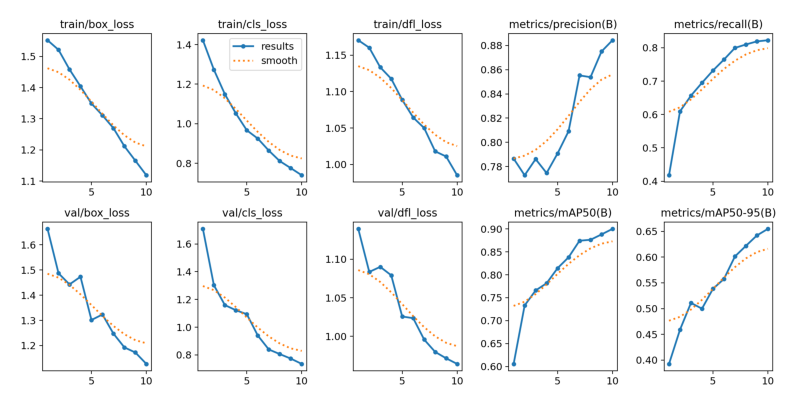

In [284]:
import matplotlib.pyplot as plt

# Provide the correct path to the image
image_path = "/Users/sohamshrivastava/Desktop/untitled_folder/runs/detect/solar_panels_model3/results.png"

# Read and display the image
img = plt.imread(image_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()


We can see that our losses are converging. There are ups an downs but if we increase the number of epochs and other tune hyperparameters then it could be much better. 

In [ ]:
# lets take 5 images from test set
test_images = ["/Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_0_y0_7840_dxdy_416.tif",
               "/Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_362_y0_6722_dxdy_416.tif",
               "/Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_581_y0_6899_dxdy_416.tif",
               "/Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_689_y0_6617_dxdy_416.tif",
               "/Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_744_y0_8126_dxdy_416.tif"]


In [111]:
model = YOLO("/Users/sohamshrivastava/Desktop/untitled_folder/runs/detect/solar_panels_model3/weights/best.pt")


In [282]:
import cv2
import torch
from ultralytics import YOLO

test_images_path = "/Users/sohamshrivastava/Desktop/untitled_folder/train_val/images"  # Folder containing test images
test_labels_path = "/Users/sohamshrivastava/Desktop/untitled_folder/train_val/labels"  # Folder containing test labels

# Get list of test images
image_files_2 = []
for f in os.listdir(test_images_path):
    if f.endswith(".tif"):
        image_files_2.append(f)

# random 3 images
random_images = random.sample(image_files, 3)


In [281]:
gt_clr = (0, 255, 0)  # Green for ground truth
pred_clr = (255, 0, 0)  # blue for predictions

In [280]:
# reading YOLO annotation files
def read_yolo_labels(label_path):
    boxes = []
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            x_center, y_center, w, h = map(float, parts[1:])
            boxes.append((x_center, y_center, w, h))
    return boxes

In [279]:
# converting YOLO format to pixel format
def yolo_to_pixel(boxes, img_w, img_h):
    pixel_boxes = []
    for box in boxes:
        x_c, y_c, w, h = box
        x1 = int((x_c - w / 2) * img_w)
        y1 = int((y_c - h / 2) * img_h)
        x2 = int((x_c + w / 2) * img_w)
        y2 = int((y_c + h / 2) * img_h)
        pixel_boxes.append((x1, y1, x2, y2))
    return pixel_boxes


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_2631_y0_9764_dxdy_416.tif: 416x416 6 solar_panel_datas, 42.3ms
Speed: 0.6ms preprocess, 42.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


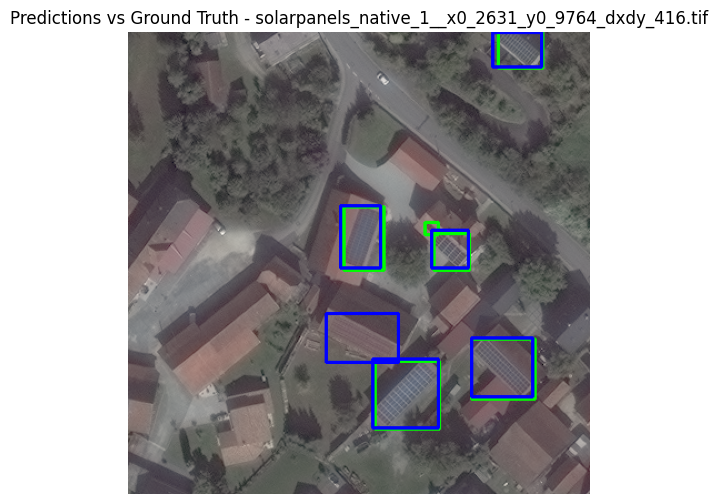


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_1__x0_2241_y0_6851_dxdy_416.tif: 416x416 8 solar_panel_datas, 87.6ms
Speed: 0.5ms preprocess, 87.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


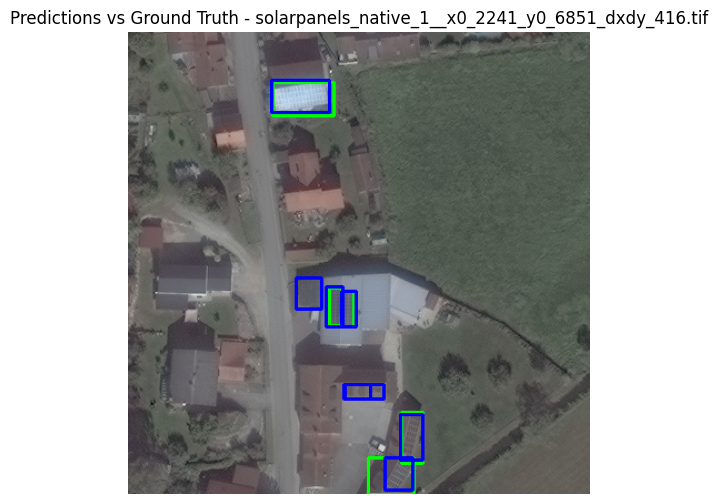


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/train_val/images/solarpanels_native_3__x0_8642_y0_6602_dxdy_416.tif: 416x416 2 solar_panel_datas, 49.8ms
Speed: 0.4ms preprocess, 49.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


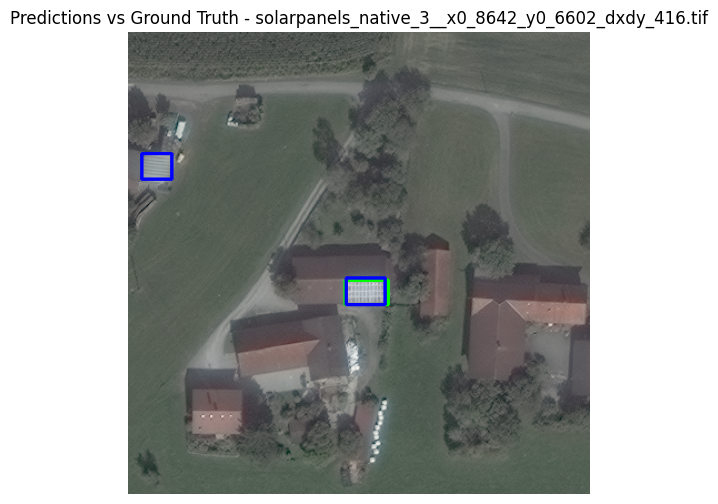

In [ ]:
# visualizing the predictions
for image_name in random_images:
    image_path = os.path.join(test_images_path, image_name)
    label_path = os.path.join(test_labels_path, image_name.replace(".tif", ".txt"))
    
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    # drawing ground truth boxes
    if os.path.exists(label_path):
        gt_boxes = read_yolo_labels(label_path)
        gt_boxes = yolo_to_pixel(gt_boxes, w, h)
        for (x1, y1, x2, y2) in gt_boxes:
            cv2.rectangle(image, (x1, y1), (x2, y2), gt_clr, 2)

    results = model(image_path)
    for result in results:
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box[:4])
            cv2.rectangle(image, (x1, y1), (x2, y2), pred_clr, 2)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions vs Ground Truth - {image_name}")
    plt.axis("off")
    plt.show()


In [ ]:
TEST_images_path = "val/images"
GT_labels_path = "val/labels"

In [ ]:
# function to read YOLO format labels and convert them to pixel coordinates
def read_yolo_labels_1(label_path, img_w, img_h):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            values = line.strip().split()
            if len(values) == 5:
                category, x_c, y_c, w, h = map(float, values)
                x1 = int((x_c - w / 2) * img_w)
                y1 = int((y_c - h / 2) * img_h)
                x2 = int((x_c + w / 2) * img_w)
                y2 = int((y_c + h / 2) * img_h)
                boxes.append([x1, y1, x2, y2, int(category)])
    return np.array(boxes) if boxes else np.empty((0, 5)) 


In [ ]:
from tqdm import tqdm
all_predictions = []
all_ground_truths = []

# list all the images 
image_files_3 = []
for f in os.listdir(TEST_images_path):
    if f.endswith('.tif'):
        image_files_3.append(f)

# running on test images
for img_file in tqdm(image_files, desc="Evaluating"):
    img_path = os.path.join(TEST_images_path, img_file)
    label_path = os.path.join(GT_labels_path, img_file.replace(".tif", ".txt"))

    image = cv2.imread(img_path)
    if image is None:
        continue 
    original_h, original_w, _ = image.shape # original image dimensions

    if os.path.exists(label_path):
        gt_boxes = read_yolo_labels_1(label_path, original_w, original_h)
        all_ground_truths.append(sv.Detections(xyxy=gt_boxes[:, :4], class_id=gt_boxes[:, 4]))

    # YOLO prediction
    results = model(img_path, imgsz=416, conf=0.25)
    for result in results:
        if result.boxes is not None:
            pred_boxes = result.boxes.xyxy.cpu().numpy()  # Convert to numpy
            pred_scores = result.boxes.conf.cpu().numpy()  # Confidence scores
            pred_classes = result.boxes.cls.cpu().numpy()  # Class labels
            detections = sv.Detections(xyxy=pred_boxes, confidence=pred_scores, class_id=pred_classes)
            all_predictions.append(detections)


Evaluating:   0%|          | 0/392 [00:00<?, ?it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8629_y0_10613_dxdy_416.tif: 416x416 22 solar_panel_datas, 144.8ms
Speed: 3.1ms preprocess, 144.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   0%|          | 1/392 [00:00<01:03,  6.16it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_3638_y0_13147_dxdy_416.tif: 416x416 5 solar_panel_datas, 58.8ms
Speed: 0.7ms preprocess, 58.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9860_y0_10721_dxdy_416.tif: 416x416 5 solar_panel_datas, 55.8ms
Speed: 0.9ms preprocess, 55.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   1%|          | 3/392 [00:00<00:35, 11.01it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8107_y0_12193_dxdy_416.tif: 416x416 30 solar_panel_datas, 56.9ms
Speed: 0.4ms preprocess, 56.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_11699_y0_346_dxdy_416.tif: 416x416 2 solar_panel_datas, 45.7ms
Speed: 0.5ms preprocess, 45.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   1%|▏         | 5/392 [00:00<00:28, 13.44it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7991_y0_12360_dxdy_416.tif: 416x416 8 solar_panel_datas, 34.8ms
Speed: 0.4ms preprocess, 34.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10105_y0_14149_dxdy_416.tif: 416x416 2 solar_panel_datas, 73.2ms
Speed: 0.4ms preprocess, 73.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   2%|▏         | 7/392 [00:00<00:26, 14.68it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4697_y0_6044_dxdy_416.tif: 416x416 6 solar_panel_datas, 36.8ms
Speed: 0.4ms preprocess, 36.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6608_y0_10941_dxdy_416.tif: 416x416 7 solar_panel_datas, 38.6ms
Speed: 0.6ms preprocess, 38.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7400_y0_10892_dxdy_416.tif: 416x416 2 solar_panel_datas, 45.4ms
Speed: 0.6ms preprocess, 45.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   3%|▎         | 10/392 [00:00<00:22, 16.86it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6567_y0_12148_dxdy_416.tif: 416x416 10 solar_panel_datas, 39.5ms
Speed: 0.7ms preprocess, 39.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_10633_y0_5756_dxdy_416.tif: 416x416 3 solar_panel_datas, 42.9ms
Speed: 0.4ms preprocess, 42.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   3%|▎         | 12/392 [00:00<00:22, 16.83it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9432_y0_14240_dxdy_416.tif: 416x416 3 solar_panel_datas, 83.8ms
Speed: 0.8ms preprocess, 83.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2282_y0_7116_dxdy_416.tif: 416x416 6 solar_panel_datas, 33.8ms
Speed: 0.6ms preprocess, 33.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   4%|▎         | 14/392 [00:00<00:24, 15.52it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7940_y0_4935_dxdy_416.tif: 416x416 1 solar_panel_data, 37.8ms
Speed: 0.8ms preprocess, 37.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_437_y0_7966_dxdy_416.tif: 416x416 5 solar_panel_datas, 33.2ms
Speed: 0.4ms preprocess, 33.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_14706_y0_207_dxdy_416.tif: 416x416 2 solar_panel_datas, 35.0ms
Speed: 0.4ms preprocess, 35.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   4%|▍         | 17/392 [00:01<00:21, 17.76it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5423_y0_1288_dxdy_416.tif: 416x416 4 solar_panel_datas, 37.4ms
Speed: 0.5ms preprocess, 37.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_4200_y0_13467_dxdy_416.tif: 416x416 4 solar_panel_datas, 38.9ms
Speed: 0.4ms preprocess, 38.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6717_y0_10647_dxdy_416.tif: 416x416 (no detections), 36.1ms
Speed: 0.4ms preprocess, 36.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   5%|▌         | 20/392 [00:01<00:19, 19.38it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1474_y0_7002_dxdy_416.tif: 416x416 10 solar_panel_datas, 40.0ms
Speed: 0.4ms preprocess, 40.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9353_y0_0_dxdy_416.tif: 416x416 5 solar_panel_datas, 38.0ms
Speed: 0.7ms preprocess, 38.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_338_y0_7199_dxdy_416.tif: 416x416 11 solar_panel_datas, 34.4ms
Speed: 0.4ms preprocess, 34.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   6%|▌         | 23/392 [00:01<00:18, 20.48it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10395_y0_10175_dxdy_416.tif: 416x416 14 solar_panel_datas, 76.0ms
Speed: 0.4ms preprocess, 76.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10059_y0_11835_dxdy_416.tif: 416x416 5 solar_panel_datas, 37.4ms
Speed: 0.4ms preprocess, 37.4ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: 416x416 11 solar_panel_datas, 35.1ms
Speed: 0.4ms preprocess, 35.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   7%|▋         | 26/392 [00:01<00:18, 19.51it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10870_y0_9345_dxdy_416.tif: 416x416 22 solar_panel_datas, 40.8ms
Speed: 0.4ms preprocess, 40.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11066_y0_12067_dxdy_416.tif: 416x416 3 solar_panel_datas, 36.4ms
Speed: 0.4ms preprocess, 36.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2099_y0_9497_dxdy_416.tif: 416x416 7 solar_panel_datas, 36.0ms
Speed: 0.4ms preprocess, 36.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   7%|▋         | 29/392 [00:01<00:17, 20.32it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11603_y0_9171_dxdy_416.tif: 416x416 48 solar_panel_datas, 38.6ms
Speed: 0.4ms preprocess, 38.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6077_y0_8945_dxdy_416.tif: 416x416 3 solar_panel_datas, 29.5ms
Speed: 0.4ms preprocess, 29.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3690_y0_12498_dxdy_416.tif: 416x416 11 solar_panel_datas, 34.5ms
Speed: 0.3ms preprocess, 34.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   8%|▊         | 32/392 [00:01<00:16, 21.52it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2116_y0_7055_dxdy_416.tif: 416x416 10 solar_panel_datas, 35.1ms
Speed: 0.3ms preprocess, 35.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_445_y0_11136_dxdy_416.tif: 416x416 33 solar_panel_datas, 34.5ms
Speed: 0.4ms preprocess, 34.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5091_y0_6518_dxdy_416.tif: 416x416 13 solar_panel_datas, 30.8ms
Speed: 0.3ms preprocess, 30.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:   9%|▉         | 35/392 [00:01<00:15, 22.57it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2140_y0_6241_dxdy_416.tif: 416x416 10 solar_panel_datas, 66.7ms
Speed: 0.4ms preprocess, 66.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_615_y0_6709_dxdy_416.tif: 416x416 8 solar_panel_datas, 34.4ms
Speed: 0.5ms preprocess, 34.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1943_y0_7104_dxdy_416.tif: 416x416 9 solar_panel_datas, 31.1ms
Speed: 0.4ms preprocess, 31.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  10%|▉         | 38/392 [00:02<00:16, 21.72it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_462_y0_7637_dxdy_416.tif: 416x416 5 solar_panel_datas, 32.2ms
Speed: 0.4ms preprocess, 32.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2636_y0_5101_dxdy_416.tif: 416x416 42 solar_panel_datas, 30.3ms
Speed: 0.3ms preprocess, 30.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7950_dxdy_416.tif: 416x416 8 solar_panel_datas, 30.9ms
Speed: 0.3ms preprocess, 30.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  10%|█         | 41/392 [00:02<00:15, 23.03it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4427_y0_12896_dxdy_416.tif: 416x416 4 solar_panel_datas, 34.1ms
Speed: 0.4ms preprocess, 34.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_10439_y0_13066_dxdy_416.tif: 416x416 2 solar_panel_datas, 30.9ms
Speed: 0.3ms preprocess, 30.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10153_y0_9991_dxdy_416.tif: 416x416 43 solar_panel_datas, 30.0ms
Speed: 0.4ms preprocess, 30.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  11%|█         | 44/392 [00:02<00:14, 24.10it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4497_y0_12678_dxdy_416.tif: 416x416 7 solar_panel_datas, 36.1ms
Speed: 0.4ms preprocess, 36.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1380_y0_10215_dxdy_416.tif: 416x416 6 solar_panel_datas, 29.8ms
Speed: 0.4ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5812_y0_6792_dxdy_416.tif: 416x416 6 solar_panel_datas, 27.3ms
Speed: 0.3ms preprocess, 27.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  12%|█▏        | 47/392 [00:02<00:13, 25.00it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3674_y0_12943_dxdy_416.tif: 416x416 11 solar_panel_datas, 80.8ms
Speed: 0.3ms preprocess, 80.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3699_y0_12596_dxdy_416.tif: 416x416 7 solar_panel_datas, 82.8ms
Speed: 0.4ms preprocess, 82.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9283_y0_3998_dxdy_416.tif: 416x416 7 solar_panel_datas, 33.7ms
Speed: 0.4ms preprocess, 33.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  13%|█▎        | 50/392 [00:02<00:16, 20.23it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_675_y0_7685_dxdy_416.tif: 416x416 12 solar_panel_datas, 36.2ms
Speed: 0.4ms preprocess, 36.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_11642_dxdy_416.tif: 416x416 46 solar_panel_datas, 27.2ms
Speed: 0.4ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5752_y0_1032_dxdy_416.tif: 416x416 3 solar_panel_datas, 31.6ms
Speed: 0.4ms preprocess, 31.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  14%|█▎        | 53/392 [00:02<00:15, 21.76it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5171_y0_14554_dxdy_416.tif: 416x416 9 solar_panel_datas, 36.0ms
Speed: 0.4ms preprocess, 36.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8229_y0_13624_dxdy_416.tif: 416x416 4 solar_panel_datas, 38.2ms
Speed: 0.5ms preprocess, 38.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5677_y0_6633_dxdy_416.tif: 416x416 8 solar_panel_datas, 32.5ms
Speed: 0.4ms preprocess, 32.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  14%|█▍        | 56/392 [00:02<00:14, 22.45it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6775_y0_6250_dxdy_416.tif: 416x416 3 solar_panel_datas, 44.6ms
Speed: 0.3ms preprocess, 44.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8195_y0_12677_dxdy_416.tif: 416x416 9 solar_panel_datas, 32.1ms
Speed: 0.4ms preprocess, 32.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5395_y0_12908_dxdy_416.tif: 416x416 10 solar_panel_datas, 29.7ms
Speed: 0.4ms preprocess, 29.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  15%|█▌        | 59/392 [00:02<00:14, 23.09it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5909_y0_8922_dxdy_416.tif: 416x416 3 solar_panel_datas, 34.9ms
Speed: 0.4ms preprocess, 34.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5933_y0_12270_dxdy_416.tif: 416x416 7 solar_panel_datas, 31.4ms
Speed: 0.4ms preprocess, 31.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1081_y0_6362_dxdy_416.tif: 416x416 15 solar_panel_datas, 31.4ms
Speed: 0.4ms preprocess, 31.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  16%|█▌        | 62/392 [00:03<00:13, 24.02it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4033_y0_13297_dxdy_416.tif: 416x416 12 solar_panel_datas, 77.1ms
Speed: 0.4ms preprocess, 77.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8499_y0_8005_dxdy_416.tif: 416x416 13 solar_panel_datas, 31.1ms
Speed: 0.4ms preprocess, 31.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1080_y0_7916_dxdy_416.tif: 416x416 10 solar_panel_datas, 27.2ms
Speed: 0.4ms preprocess, 27.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  17%|█▋        | 65/392 [00:03<00:14, 22.43it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9119_y0_10931_dxdy_416.tif: 416x416 6 solar_panel_datas, 36.0ms
Speed: 0.5ms preprocess, 36.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2777_y0_5191_dxdy_416.tif: 416x416 52 solar_panel_datas, 34.0ms
Speed: 0.3ms preprocess, 34.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7748_y0_9311_dxdy_416.tif: 416x416 5 solar_panel_datas, 29.9ms
Speed: 0.4ms preprocess, 29.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  17%|█▋        | 68/392 [00:03<00:13, 23.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_6876_y0_9926_dxdy_416.tif: 416x416 7 solar_panel_datas, 32.1ms
Speed: 0.4ms preprocess, 32.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12826_y0_15584_dxdy_416.tif: 416x416 2 solar_panel_datas, 30.3ms
Speed: 0.4ms preprocess, 30.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11997_y0_11247_dxdy_416.tif: 416x416 12 solar_panel_datas, 31.0ms
Speed: 0.4ms preprocess, 31.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  18%|█▊        | 71/392 [00:03<00:13, 24.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_9469_dxdy_416.tif: 416x416 1 solar_panel_data, 37.0ms
Speed: 0.4ms preprocess, 37.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8405_y0_13882_dxdy_416.tif: 416x416 4 solar_panel_datas, 29.8ms
Speed: 0.4ms preprocess, 29.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6860_y0_9028_dxdy_416.tif: 416x416 14 solar_panel_datas, 32.0ms
Speed: 0.4ms preprocess, 32.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  19%|█▉        | 74/392 [00:03<00:12, 24.72it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_15_y0_11502_dxdy_416.tif: 416x416 53 solar_panel_datas, 47.5ms
Speed: 0.4ms preprocess, 47.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9715_y0_9476_dxdy_416.tif: 416x416 4 solar_panel_datas, 39.8ms
Speed: 0.3ms preprocess, 39.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_318_y0_7394_dxdy_416.tif: 416x416 6 solar_panel_datas, 67.8ms
Speed: 0.4ms preprocess, 67.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  20%|█▉        | 77/392 [00:03<00:14, 22.02it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1155_y0_7773_dxdy_416.tif: 416x416 14 solar_panel_datas, 35.9ms
Speed: 0.4ms preprocess, 35.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1501_y0_10325_dxdy_416.tif: 416x416 2 solar_panel_datas, 29.9ms
Speed: 0.4ms preprocess, 29.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9851_y0_14286_dxdy_416.tif: 416x416 6 solar_panel_datas, 29.9ms
Speed: 0.4ms preprocess, 29.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  20%|██        | 80/392 [00:03<00:13, 23.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1591_y0_8851_dxdy_416.tif: 416x416 7 solar_panel_datas, 36.2ms
Speed: 0.5ms preprocess, 36.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2164_y0_8552_dxdy_416.tif: 416x416 3 solar_panel_datas, 36.3ms
Speed: 0.4ms preprocess, 36.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9847_y0_14845_dxdy_416.tif: 416x416 10 solar_panel_datas, 25.3ms
Speed: 0.4ms preprocess, 25.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  21%|██        | 83/392 [00:03<00:12, 24.04it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6392_y0_10597_dxdy_416.tif: 416x416 7 solar_panel_datas, 34.5ms
Speed: 0.3ms preprocess, 34.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8573_y0_11090_dxdy_416.tif: 416x416 20 solar_panel_datas, 29.7ms
Speed: 0.4ms preprocess, 29.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8348_y0_9251_dxdy_416.tif: 416x416 6 solar_panel_datas, 34.2ms
Speed: 0.4ms preprocess, 34.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  22%|██▏       | 86/392 [00:04<00:12, 24.60it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_7062_y0_9845_dxdy_416.tif: 416x416 7 solar_panel_datas, 67.9ms
Speed: 0.4ms preprocess, 67.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2835_y0_7926_dxdy_416.tif: 416x416 11 solar_panel_datas, 29.3ms
Speed: 0.4ms preprocess, 29.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_606_y0_10888_dxdy_416.tif: 416x416 46 solar_panel_datas, 29.3ms
Speed: 0.4ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  23%|██▎       | 89/392 [00:04<00:12, 23.40it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11851_y0_9196_dxdy_416.tif: 416x416 49 solar_panel_datas, 35.7ms
Speed: 0.4ms preprocess, 35.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11087_y0_9825_dxdy_416.tif: 416x416 21 solar_panel_datas, 31.4ms
Speed: 0.4ms preprocess, 31.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9056_y0_4753_dxdy_416.tif: 416x416 5 solar_panel_datas, 34.4ms
Speed: 0.4ms preprocess, 34.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  23%|██▎       | 92/392 [00:04<00:12, 24.02it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5120_y0_1150_dxdy_416.tif: 416x416 3 solar_panel_datas, 36.4ms
Speed: 0.4ms preprocess, 36.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_3662_y0_15968_dxdy_416.tif: 416x416 4 solar_panel_datas, 32.8ms
Speed: 0.3ms preprocess, 32.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8507_y0_10276_dxdy_416.tif: 416x416 7 solar_panel_datas, 27.1ms
Speed: 0.4ms preprocess, 27.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  24%|██▍       | 95/392 [00:04<00:11, 24.77it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8174_y0_10932_dxdy_416.tif: 416x416 1 solar_panel_data, 32.8ms
Speed: 0.4ms preprocess, 32.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2733_y0_5068_dxdy_416.tif: 416x416 51 solar_panel_datas, 29.7ms
Speed: 0.4ms preprocess, 29.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_14309_y0_7792_dxdy_416.tif: 416x416 9 solar_panel_datas, 28.5ms
Speed: 0.3ms preprocess, 28.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  25%|██▌       | 98/392 [00:04<00:11, 25.55it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2208_y0_7134_dxdy_416.tif: 416x416 9 solar_panel_datas, 79.8ms
Speed: 0.4ms preprocess, 79.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_1002_y0_8269_dxdy_416.tif: 416x416 4 solar_panel_datas, 32.5ms
Speed: 0.3ms preprocess, 32.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_903_y0_6236_dxdy_416.tif: 416x416 11 solar_panel_datas, 30.4ms
Speed: 0.5ms preprocess, 30.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  26%|██▌       | 101/392 [00:04<00:12, 23.01it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7957_y0_8387_dxdy_416.tif: 416x416 35 solar_panel_datas, 35.9ms
Speed: 0.4ms preprocess, 35.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6129_y0_8840_dxdy_416.tif: 416x416 3 solar_panel_datas, 33.3ms
Speed: 0.4ms preprocess, 33.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8591_y0_4029_dxdy_416.tif: 416x416 24 solar_panel_datas, 27.4ms
Speed: 0.4ms preprocess, 27.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  27%|██▋       | 104/392 [00:04<00:12, 23.88it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1143_y0_40_dxdy_416.tif: 416x416 2 solar_panel_datas, 34.3ms
Speed: 0.4ms preprocess, 34.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10977_y0_9825_dxdy_416.tif: 416x416 19 solar_panel_datas, 32.6ms
Speed: 0.4ms preprocess, 32.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_3151_y0_3631_dxdy_416.tif: 416x416 3 solar_panel_datas, 32.3ms
Speed: 0.3ms preprocess, 32.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  27%|██▋       | 107/392 [00:04<00:11, 24.42it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_623_y0_10650_dxdy_416.tif: 416x416 58 solar_panel_datas, 38.6ms
Speed: 0.3ms preprocess, 38.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_3675_y0_12932_dxdy_416.tif: 416x416 10 solar_panel_datas, 33.4ms
Speed: 0.4ms preprocess, 33.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7538_y0_9868_dxdy_416.tif: 416x416 13 solar_panel_datas, 34.5ms
Speed: 0.4ms preprocess, 34.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  28%|██▊       | 110/392 [00:05<00:11, 24.36it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2780_y0_5096_dxdy_416.tif: 416x416 53 solar_panel_datas, 73.1ms
Speed: 0.4ms preprocess, 73.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6846_y0_12353_dxdy_416.tif: 416x416 42 solar_panel_datas, 30.0ms
Speed: 0.3ms preprocess, 30.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_751_y0_10352_dxdy_416.tif: 416x416 45 solar_panel_datas, 31.2ms
Speed: 0.3ms preprocess, 31.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  29%|██▉       | 113/392 [00:05<00:12, 22.82it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5345_y0_1443_dxdy_416.tif: 416x416 1 solar_panel_data, 37.1ms
Speed: 0.3ms preprocess, 37.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_13407_y0_5541_dxdy_416.tif: 416x416 8 solar_panel_datas, 27.9ms
Speed: 0.4ms preprocess, 27.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3881_y0_11655_dxdy_416.tif: 416x416 26 solar_panel_datas, 29.4ms
Speed: 0.3ms preprocess, 29.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  30%|██▉       | 116/392 [00:05<00:11, 23.86it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3802_y0_11549_dxdy_416.tif: 416x416 27 solar_panel_datas, 37.2ms
Speed: 0.3ms preprocess, 37.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7303_dxdy_416.tif: 416x416 8 solar_panel_datas, 36.0ms
Speed: 0.4ms preprocess, 36.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4861_y0_6232_dxdy_416.tif: 416x416 9 solar_panel_datas, 31.3ms
Speed: 0.4ms preprocess, 31.3ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  30%|███       | 119/392 [00:05<00:11, 24.10it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6474_y0_12162_dxdy_416.tif: 416x416 19 solar_panel_datas, 40.0ms
Speed: 0.4ms preprocess, 40.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6746_y0_12301_dxdy_416.tif: 416x416 49 solar_panel_datas, 32.8ms
Speed: 0.4ms preprocess, 32.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1214_y0_3647_dxdy_416.tif: 416x416 3 solar_panel_datas, 32.2ms
Speed: 0.4ms preprocess, 32.2ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  31%|███       | 122/392 [00:05<00:11, 24.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_3214_y0_1973_dxdy_416.tif: 416x416 2 solar_panel_datas, 69.2ms
Speed: 0.4ms preprocess, 69.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8357_y0_12627_dxdy_416.tif: 416x416 6 solar_panel_datas, 31.5ms
Speed: 0.4ms preprocess, 31.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6618_y0_12135_dxdy_416.tif: 416x416 48 solar_panel_datas, 33.6ms
Speed: 0.4ms preprocess, 33.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  32%|███▏      | 125/392 [00:05<00:11, 22.73it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_3873_y0_15728_dxdy_416.tif: 416x416 3 solar_panel_datas, 33.8ms
Speed: 0.4ms preprocess, 33.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3791_y0_3095_dxdy_416.tif: 416x416 1 solar_panel_data, 31.9ms
Speed: 0.3ms preprocess, 31.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3904_y0_11864_dxdy_416.tif: 416x416 11 solar_panel_datas, 30.5ms
Speed: 0.4ms preprocess, 30.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  33%|███▎      | 128/392 [00:05<00:11, 23.78it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9490_y0_10558_dxdy_416.tif: 416x416 13 solar_panel_datas, 34.8ms
Speed: 0.4ms preprocess, 34.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8401_y0_3867_dxdy_416.tif: 416x416 19 solar_panel_datas, 29.0ms
Speed: 0.4ms preprocess, 29.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_7957_y0_2403_dxdy_416.tif: 416x416 13 solar_panel_datas, 29.0ms
Speed: 0.4ms preprocess, 29.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  33%|███▎      | 131/392 [00:05<00:10, 24.84it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_14215_dxdy_416.tif: 416x416 12 solar_panel_datas, 36.0ms
Speed: 0.3ms preprocess, 36.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2829_y0_5144_dxdy_416.tif: 416x416 60 solar_panel_datas, 33.4ms
Speed: 0.4ms preprocess, 33.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_14300_y0_7830_dxdy_416.tif: 416x416 7 solar_panel_datas, 32.5ms
Speed: 0.4ms preprocess, 32.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  34%|███▍      | 134/392 [00:06<00:10, 25.08it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_1683_y0_9664_dxdy_416.tif: 416x416 2 solar_panel_datas, 69.8ms
Speed: 0.5ms preprocess, 69.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3715_y0_12487_dxdy_416.tif: 416x416 10 solar_panel_datas, 33.6ms
Speed: 0.4ms preprocess, 33.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2379_y0_6385_dxdy_416.tif: 416x416 3 solar_panel_datas, 30.0ms
Speed: 0.5ms preprocess, 30.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  35%|███▍      | 137/392 [00:06<00:11, 22.98it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1583_y0_7360_dxdy_416.tif: 416x416 9 solar_panel_datas, 34.3ms
Speed: 0.4ms preprocess, 34.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7083_y0_9790_dxdy_416.tif: 416x416 14 solar_panel_datas, 32.4ms
Speed: 0.4ms preprocess, 32.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_361_y0_6855_dxdy_416.tif: 416x416 13 solar_panel_datas, 31.6ms
Speed: 0.4ms preprocess, 31.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  36%|███▌      | 140/392 [00:06<00:10, 23.92it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1498_y0_9554_dxdy_416.tif: 416x416 10 solar_panel_datas, 35.1ms
Speed: 0.4ms preprocess, 35.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_3794_y0_7793_dxdy_416.tif: 416x416 5 solar_panel_datas, 33.0ms
Speed: 0.4ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12234_y0_11597_dxdy_416.tif: 416x416 12 solar_panel_datas, 29.6ms
Speed: 0.4ms preprocess, 29.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  36%|███▋      | 143/392 [00:06<00:10, 24.63it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1389_y0_9180_dxdy_416.tif: 416x416 12 solar_panel_datas, 37.8ms
Speed: 0.3ms preprocess, 37.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8591_y0_10476_dxdy_416.tif: 416x416 21 solar_panel_datas, 31.1ms
Speed: 0.4ms preprocess, 31.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9651_y0_14624_dxdy_416.tif: 416x416 15 solar_panel_datas, 29.9ms
Speed: 0.4ms preprocess, 29.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  37%|███▋      | 146/392 [00:06<00:09, 25.15it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8551_y0_11902_dxdy_416.tif: 416x416 3 solar_panel_datas, 72.8ms
Speed: 0.4ms preprocess, 72.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5245_y0_5664_dxdy_416.tif: 416x416 12 solar_panel_datas, 31.6ms
Speed: 0.4ms preprocess, 31.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9161_y0_12925_dxdy_416.tif: 416x416 7 solar_panel_datas, 31.9ms
Speed: 0.4ms preprocess, 31.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  38%|███▊      | 149/392 [00:06<00:10, 23.21it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7868_y0_8363_dxdy_416.tif: 416x416 39 solar_panel_datas, 39.0ms
Speed: 0.4ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_14471_dxdy_416.tif: 416x416 8 solar_panel_datas, 34.3ms
Speed: 0.4ms preprocess, 34.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8177_y0_0_dxdy_416.tif: 416x416 2 solar_panel_datas, 40.4ms
Speed: 0.6ms preprocess, 40.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  39%|███▉      | 152/392 [00:06<00:10, 23.22it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6230_y0_12244_dxdy_416.tif: 416x416 15 solar_panel_datas, 43.8ms
Speed: 0.7ms preprocess, 43.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1383_y0_8020_dxdy_416.tif: 416x416 4 solar_panel_datas, 37.8ms
Speed: 0.4ms preprocess, 37.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2431_y0_4920_dxdy_416.tif: 416x416 8 solar_panel_datas, 36.0ms
Speed: 0.4ms preprocess, 36.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  40%|███▉      | 155/392 [00:06<00:10, 22.95it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5291_y0_5695_dxdy_416.tif: 416x416 11 solar_panel_datas, 40.5ms
Speed: 0.4ms preprocess, 40.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1808_y0_6881_dxdy_416.tif: 416x416 20 solar_panel_datas, 37.2ms
Speed: 0.5ms preprocess, 37.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8454_y0_8323_dxdy_416.tif: 416x416 17 solar_panel_datas, 43.6ms
Speed: 0.4ms preprocess, 43.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  40%|████      | 158/392 [00:07<00:10, 22.51it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8329_y0_12227_dxdy_416.tif: 416x416 11 solar_panel_datas, 78.1ms
Speed: 0.4ms preprocess, 78.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4206_y0_15221_dxdy_416.tif: 416x416 6 solar_panel_datas, 37.9ms
Speed: 0.4ms preprocess, 37.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1044_y0_7709_dxdy_416.tif: 416x416 5 solar_panel_datas, 31.9ms
Speed: 0.4ms preprocess, 31.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  41%|████      | 161/392 [00:07<00:10, 21.09it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_1940_y0_10164_dxdy_416.tif: 416x416 4 solar_panel_datas, 39.2ms
Speed: 0.4ms preprocess, 39.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_11265_y0_0_dxdy_416.tif: 416x416 3 solar_panel_datas, 36.2ms
Speed: 0.4ms preprocess, 36.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5745_y0_13219_dxdy_416.tif: 416x416 8 solar_panel_datas, 37.9ms
Speed: 0.4ms preprocess, 37.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  42%|████▏     | 164/392 [00:07<00:10, 21.58it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_9414_dxdy_416.tif: 416x416 1 solar_panel_data, 39.6ms
Speed: 0.6ms preprocess, 39.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4823_y0_13720_dxdy_416.tif: 416x416 11 solar_panel_datas, 34.1ms
Speed: 0.4ms preprocess, 34.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_3530_y0_7695_dxdy_416.tif: 416x416 11 solar_panel_datas, 33.1ms
Speed: 0.4ms preprocess, 33.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  43%|████▎     | 167/392 [00:07<00:10, 22.42it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5653_y0_6167_dxdy_416.tif: 416x416 5 solar_panel_datas, 56.6ms
Speed: 0.4ms preprocess, 56.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6963_y0_9671_dxdy_416.tif: 416x416 4 solar_panel_datas, 32.8ms
Speed: 0.4ms preprocess, 32.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9428_y0_14969_dxdy_416.tif: 416x416 17 solar_panel_datas, 35.7ms
Speed: 0.4ms preprocess, 35.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  43%|████▎     | 170/392 [00:07<00:10, 21.92it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_10081_y0_11390_dxdy_416.tif: 416x416 3 solar_panel_datas, 77.1ms
Speed: 0.4ms preprocess, 77.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9436_y0_2624_dxdy_416.tif: 416x416 6 solar_panel_datas, 33.1ms
Speed: 0.4ms preprocess, 33.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1793_y0_6747_dxdy_416.tif: 416x416 20 solar_panel_datas, 29.2ms
Speed: 0.4ms preprocess, 29.2ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  44%|████▍     | 173/392 [00:07<00:10, 21.04it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8582_y0_11150_dxdy_416.tif: 416x416 16 solar_panel_datas, 35.6ms
Speed: 0.3ms preprocess, 35.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2590_y0_12857_dxdy_416.tif: 416x416 5 solar_panel_datas, 35.6ms
Speed: 0.3ms preprocess, 35.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4110_y0_9749_dxdy_416.tif: 416x416 1 solar_panel_data, 38.7ms
Speed: 0.4ms preprocess, 38.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  45%|████▍     | 176/392 [00:07<00:09, 21.89it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_2432_y0_13234_dxdy_416.tif: 416x416 11 solar_panel_datas, 35.7ms
Speed: 0.4ms preprocess, 35.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8314_y0_12090_dxdy_416.tif: 416x416 10 solar_panel_datas, 37.5ms
Speed: 0.3ms preprocess, 37.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7872_y0_8281_dxdy_416.tif: 416x416 37 solar_panel_datas, 35.0ms
Speed: 0.4ms preprocess, 35.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  46%|████▌     | 179/392 [00:08<00:09, 22.42it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8079_y0_12258_dxdy_416.tif: 416x416 34 solar_panel_datas, 39.0ms
Speed: 0.3ms preprocess, 39.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3219_y0_7702_dxdy_416.tif: 416x416 6 solar_panel_datas, 36.5ms
Speed: 0.4ms preprocess, 36.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_991_y0_8791_dxdy_416.tif: 416x416 16 solar_panel_datas, 39.2ms
Speed: 0.5ms preprocess, 39.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  46%|████▋     | 182/392 [00:08<00:09, 22.48it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_15527_y0_14122_dxdy_416.tif: 416x416 11 solar_panel_datas, 85.1ms
Speed: 0.4ms preprocess, 85.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_13908_y0_15968_dxdy_416.tif: 416x416 (no detections), 32.5ms
Speed: 0.4ms preprocess, 32.5ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5680_y0_6756_dxdy_416.tif: 416x416 8 solar_panel_datas, 31.6ms
Speed: 0.8ms preprocess, 31.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  47%|████▋     | 185/392 [00:08<00:09, 20.84it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4330_y0_15437_dxdy_416.tif: 416x416 10 solar_panel_datas, 41.2ms
Speed: 0.4ms preprocess, 41.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8239_y0_7742_dxdy_416.tif: 416x416 11 solar_panel_datas, 37.3ms
Speed: 0.4ms preprocess, 37.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_14797_dxdy_416.tif: 416x416 3 solar_panel_datas, 38.0ms
Speed: 0.4ms preprocess, 38.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  48%|████▊     | 188/392 [00:08<00:09, 21.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_31_y0_11645_dxdy_416.tif: 416x416 44 solar_panel_datas, 36.9ms
Speed: 0.4ms preprocess, 36.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7965_y0_9547_dxdy_416.tif: 416x416 5 solar_panel_datas, 35.4ms
Speed: 0.8ms preprocess, 35.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4944_y0_5896_dxdy_416.tif: 416x416 7 solar_panel_datas, 34.3ms
Speed: 0.4ms preprocess, 34.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  49%|████▊     | 191/392 [00:08<00:09, 22.06it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1062_y0_7896_dxdy_416.tif: 416x416 10 solar_panel_datas, 42.9ms
Speed: 0.4ms preprocess, 42.9ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3455_y0_13057_dxdy_416.tif: 416x416 17 solar_panel_datas, 37.3ms
Speed: 0.4ms preprocess, 37.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5938_y0_1143_dxdy_416.tif: 416x416 2 solar_panel_datas, 34.5ms
Speed: 0.4ms preprocess, 34.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  49%|████▉     | 194/392 [00:08<00:08, 22.26it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10527_y0_1093_dxdy_416.tif: 416x416 7 solar_panel_datas, 88.3ms
Speed: 0.4ms preprocess, 88.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_992_y0_6099_dxdy_416.tif: 416x416 11 solar_panel_datas, 36.7ms
Speed: 0.4ms preprocess, 36.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5690_y0_13412_dxdy_416.tif: 416x416 9 solar_panel_datas, 35.3ms
Speed: 0.4ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  50%|█████     | 197/392 [00:08<00:09, 20.33it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4508_y0_15260_dxdy_416.tif: 416x416 6 solar_panel_datas, 45.7ms
Speed: 0.4ms preprocess, 45.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8352_y0_11302_dxdy_416.tif: 416x416 8 solar_panel_datas, 31.6ms
Speed: 0.4ms preprocess, 31.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7962_y0_8558_dxdy_416.tif: 416x416 32 solar_panel_datas, 35.3ms
Speed: 0.4ms preprocess, 35.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  51%|█████     | 200/392 [00:09<00:09, 21.11it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_7960_y0_2321_dxdy_416.tif: 416x416 14 solar_panel_datas, 42.4ms
Speed: 0.5ms preprocess, 42.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5183_y0_7049_dxdy_416.tif: 416x416 2 solar_panel_datas, 34.3ms
Speed: 0.4ms preprocess, 34.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_965_y0_7803_dxdy_416.tif: 416x416 17 solar_panel_datas, 36.0ms
Speed: 0.5ms preprocess, 36.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  52%|█████▏    | 203/392 [00:09<00:08, 21.65it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8890_y0_12702_dxdy_416.tif: 416x416 6 solar_panel_datas, 39.6ms
Speed: 0.4ms preprocess, 39.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4381_y0_9621_dxdy_416.tif: 416x416 3 solar_panel_datas, 33.1ms
Speed: 0.4ms preprocess, 33.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12101_y0_11659_dxdy_416.tif: 416x416 11 solar_panel_datas, 37.8ms
Speed: 0.5ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  53%|█████▎    | 206/392 [00:09<00:08, 22.18it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2230_y0_4484_dxdy_416.tif: 416x416 17 solar_panel_datas, 77.3ms
Speed: 0.4ms preprocess, 77.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9250_y0_10525_dxdy_416.tif: 416x416 4 solar_panel_datas, 35.3ms
Speed: 0.4ms preprocess, 35.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7513_dxdy_416.tif: 416x416 2 solar_panel_datas, 36.6ms
Speed: 0.4ms preprocess, 36.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  53%|█████▎    | 209/392 [00:09<00:08, 20.69it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11680_y0_9118_dxdy_416.tif: 416x416 52 solar_panel_datas, 44.5ms
Speed: 0.4ms preprocess, 44.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9390_y0_11734_dxdy_416.tif: 416x416 3 solar_panel_datas, 40.9ms
Speed: 0.4ms preprocess, 40.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_10699_y0_7256_dxdy_416.tif: 416x416 2 solar_panel_datas, 38.5ms
Speed: 0.4ms preprocess, 38.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  54%|█████▍    | 212/392 [00:09<00:08, 20.67it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9123_y0_4518_dxdy_416.tif: 416x416 4 solar_panel_datas, 39.8ms
Speed: 0.4ms preprocess, 39.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3374_y0_12821_dxdy_416.tif: 416x416 8 solar_panel_datas, 32.0ms
Speed: 0.4ms preprocess, 32.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8096_y0_12164_dxdy_416.tif: 416x416 29 solar_panel_datas, 38.5ms
Speed: 0.4ms preprocess, 38.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  55%|█████▍    | 215/392 [00:09<00:08, 21.51it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4763_y0_13162_dxdy_416.tif: 416x416 8 solar_panel_datas, 37.2ms
Speed: 0.4ms preprocess, 37.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8943_y0_4161_dxdy_416.tif: 416x416 5 solar_panel_datas, 35.8ms
Speed: 0.4ms preprocess, 35.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_149_y0_7979_dxdy_416.tif: 416x416 8 solar_panel_datas, 32.0ms
Speed: 0.8ms preprocess, 32.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  56%|█████▌    | 218/392 [00:09<00:07, 22.36it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11647_y0_9038_dxdy_416.tif: 416x416 52 solar_panel_datas, 78.9ms
Speed: 0.4ms preprocess, 78.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5218_y0_13102_dxdy_416.tif: 416x416 6 solar_panel_datas, 38.7ms
Speed: 0.4ms preprocess, 38.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8510_y0_1500_dxdy_416.tif: 416x416 7 solar_panel_datas, 34.7ms
Speed: 0.5ms preprocess, 34.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  56%|█████▋    | 221/392 [00:10<00:08, 20.67it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3061_y0_8047_dxdy_416.tif: 416x416 8 solar_panel_datas, 40.6ms
Speed: 0.4ms preprocess, 40.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7603_y0_9742_dxdy_416.tif: 416x416 14 solar_panel_datas, 34.8ms
Speed: 0.4ms preprocess, 34.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_13473_y0_14904_dxdy_416.tif: 416x416 2 solar_panel_datas, 47.5ms
Speed: 0.4ms preprocess, 47.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  57%|█████▋    | 224/392 [00:10<00:08, 20.88it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1047_y0_8876_dxdy_416.tif: 416x416 14 solar_panel_datas, 40.6ms
Speed: 0.5ms preprocess, 40.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2881_y0_5267_dxdy_416.tif: 416x416 49 solar_panel_datas, 39.9ms
Speed: 0.6ms preprocess, 39.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2964_y0_10181_dxdy_416.tif: 416x416 14 solar_panel_datas, 32.7ms
Speed: 0.3ms preprocess, 32.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  58%|█████▊    | 227/392 [00:10<00:07, 21.34it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5377_y0_6585_dxdy_416.tif: 416x416 11 solar_panel_datas, 38.1ms
Speed: 0.4ms preprocess, 38.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5254_y0_12464_dxdy_416.tif: 416x416 8 solar_panel_datas, 36.4ms
Speed: 0.5ms preprocess, 36.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1306_y0_7498_dxdy_416.tif: 416x416 4 solar_panel_datas, 38.1ms
Speed: 0.6ms preprocess, 38.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  59%|█████▊    | 230/392 [00:10<00:07, 21.82it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8458_y0_11268_dxdy_416.tif: 416x416 9 solar_panel_datas, 74.9ms
Speed: 0.3ms preprocess, 74.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_4747_y0_12358_dxdy_416.tif: 416x416 10 solar_panel_datas, 36.6ms
Speed: 0.4ms preprocess, 36.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11768_y0_9132_dxdy_416.tif: 416x416 52 solar_panel_datas, 37.0ms
Speed: 0.5ms preprocess, 37.0ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  59%|█████▉    | 233/392 [00:10<00:07, 20.46it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5816_y0_5494_dxdy_416.tif: 416x416 12 solar_panel_datas, 43.1ms
Speed: 0.5ms preprocess, 43.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9804_y0_11203_dxdy_416.tif: 416x416 12 solar_panel_datas, 32.7ms
Speed: 0.6ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_13393_y0_9948_dxdy_416.tif: 416x416 5 solar_panel_datas, 35.7ms
Speed: 0.4ms preprocess, 35.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  60%|██████    | 236/392 [00:10<00:07, 21.13it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7632_y0_9852_dxdy_416.tif: 416x416 10 solar_panel_datas, 40.8ms
Speed: 0.4ms preprocess, 40.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7403_y0_13361_dxdy_416.tif: 416x416 1 solar_panel_data, 35.0ms
Speed: 0.5ms preprocess, 35.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8676_y0_12301_dxdy_416.tif: 416x416 5 solar_panel_datas, 34.6ms
Speed: 0.4ms preprocess, 34.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  61%|██████    | 239/392 [00:10<00:07, 21.79it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9071_y0_14618_dxdy_416.tif: 416x416 14 solar_panel_datas, 38.6ms
Speed: 0.4ms preprocess, 38.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8104_y0_14206_dxdy_416.tif: 416x416 13 solar_panel_datas, 35.3ms
Speed: 0.5ms preprocess, 35.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_7358_y0_9505_dxdy_416.tif: 416x416 10 solar_panel_datas, 34.8ms
Speed: 0.3ms preprocess, 34.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  62%|██████▏   | 242/392 [00:11<00:06, 22.28it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12356_y0_6355_dxdy_416.tif: 416x416 3 solar_panel_datas, 78.6ms
Speed: 0.4ms preprocess, 78.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_996_y0_7722_dxdy_416.tif: 416x416 17 solar_panel_datas, 37.3ms
Speed: 0.4ms preprocess, 37.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1283_y0_7097_dxdy_416.tif: 416x416 7 solar_panel_datas, 32.6ms
Speed: 0.4ms preprocess, 32.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  62%|██████▎   | 245/392 [00:11<00:07, 20.78it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_2887_y0_1909_dxdy_416.tif: 416x416 3 solar_panel_datas, 38.4ms
Speed: 0.4ms preprocess, 38.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_733_y0_10494_dxdy_416.tif: 416x416 71 solar_panel_datas, 34.6ms
Speed: 0.5ms preprocess, 34.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_14256_dxdy_416.tif: 416x416 12 solar_panel_datas, 39.4ms
Speed: 0.4ms preprocess, 39.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  63%|██████▎   | 248/392 [00:11<00:06, 21.50it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_975_y0_8473_dxdy_416.tif: 416x416 5 solar_panel_datas, 42.3ms
Speed: 0.4ms preprocess, 42.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_546_y0_10650_dxdy_416.tif: 416x416 54 solar_panel_datas, 45.8ms
Speed: 0.4ms preprocess, 45.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5187_y0_6039_dxdy_416.tif: 416x416 13 solar_panel_datas, 38.3ms
Speed: 0.4ms preprocess, 38.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  64%|██████▍   | 251/392 [00:11<00:06, 21.43it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_3547_y0_0_dxdy_416.tif: 416x416 6 solar_panel_datas, 42.3ms
Speed: 0.4ms preprocess, 42.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_13769_y0_14835_dxdy_416.tif: 416x416 3 solar_panel_datas, 36.2ms
Speed: 0.3ms preprocess, 36.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9444_y0_12950_dxdy_416.tif: 416x416 7 solar_panel_datas, 41.4ms
Speed: 0.3ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  65%|██████▍   | 254/392 [00:11<00:06, 21.49it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_14200_y0_3871_dxdy_416.tif: 416x416 1 solar_panel_data, 80.3ms
Speed: 0.5ms preprocess, 80.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3894_y0_13303_dxdy_416.tif: 416x416 12 solar_panel_datas, 34.7ms
Speed: 0.4ms preprocess, 34.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4769_y0_13391_dxdy_416.tif: 416x416 4 solar_panel_datas, 37.4ms
Speed: 1.0ms preprocess, 37.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  66%|██████▌   | 257/392 [00:11<00:06, 20.14it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11017_y0_14443_dxdy_416.tif: 416x416 2 solar_panel_datas, 39.1ms
Speed: 0.4ms preprocess, 39.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2472_y0_10223_dxdy_416.tif: 416x416 7 solar_panel_datas, 35.7ms
Speed: 0.4ms preprocess, 35.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7877_y0_11703_dxdy_416.tif: 416x416 7 solar_panel_datas, 32.7ms
Speed: 0.3ms preprocess, 32.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  66%|██████▋   | 260/392 [00:11<00:06, 21.23it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9917_y0_7214_dxdy_416.tif: 416x416 2 solar_panel_datas, 39.1ms
Speed: 0.4ms preprocess, 39.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7461_y0_12952_dxdy_416.tif: 416x416 5 solar_panel_datas, 32.3ms
Speed: 0.5ms preprocess, 32.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3767_y0_11534_dxdy_416.tif: 416x416 22 solar_panel_datas, 36.3ms
Speed: 0.4ms preprocess, 36.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  67%|██████▋   | 263/392 [00:12<00:05, 21.96it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10421_y0_9866_dxdy_416.tif: 416x416 31 solar_panel_datas, 43.8ms
Speed: 0.4ms preprocess, 43.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8521_y0_3883_dxdy_416.tif: 416x416 25 solar_panel_datas, 34.2ms
Speed: 0.3ms preprocess, 34.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_3057_y0_5577_dxdy_416.tif: 416x416 1 solar_panel_data, 35.0ms
Speed: 0.5ms preprocess, 35.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  68%|██████▊   | 266/392 [00:12<00:05, 22.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4310_y0_13077_dxdy_416.tif: 416x416 12 solar_panel_datas, 78.5ms
Speed: 0.4ms preprocess, 78.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8958_y0_12045_dxdy_416.tif: 416x416 13 solar_panel_datas, 36.1ms
Speed: 0.5ms preprocess, 36.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8212_y0_11441_dxdy_416.tif: 416x416 7 solar_panel_datas, 36.6ms
Speed: 0.4ms preprocess, 36.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  69%|██████▊   | 269/392 [00:12<00:05, 20.57it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1633_y0_6609_dxdy_416.tif: 416x416 11 solar_panel_datas, 37.9ms
Speed: 0.5ms preprocess, 37.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8885_y0_12210_dxdy_416.tif: 416x416 14 solar_panel_datas, 35.3ms
Speed: 0.4ms preprocess, 35.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_625_y0_8606_dxdy_416.tif: 416x416 6 solar_panel_datas, 36.9ms
Speed: 0.4ms preprocess, 36.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  69%|██████▉   | 272/392 [00:12<00:05, 21.33it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_7910_y0_2472_dxdy_416.tif: 416x416 16 solar_panel_datas, 49.6ms
Speed: 0.4ms preprocess, 49.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4316_y0_10967_dxdy_416.tif: 416x416 7 solar_panel_datas, 35.6ms
Speed: 0.5ms preprocess, 35.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8513_y0_15572_dxdy_416.tif: 416x416 4 solar_panel_datas, 35.5ms
Speed: 0.4ms preprocess, 35.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  70%|███████   | 275/392 [00:12<00:05, 21.45it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4469_y0_4656_dxdy_416.tif: 416x416 5 solar_panel_datas, 43.2ms
Speed: 0.5ms preprocess, 43.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5210_y0_7013_dxdy_416.tif: 416x416 3 solar_panel_datas, 32.5ms
Speed: 0.4ms preprocess, 32.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6737_y0_13757_dxdy_416.tif: 416x416 4 solar_panel_datas, 36.4ms
Speed: 0.5ms preprocess, 36.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  71%|███████   | 278/392 [00:12<00:05, 21.90it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2671_y0_5201_dxdy_416.tif: 416x416 43 solar_panel_datas, 77.8ms
Speed: 0.4ms preprocess, 77.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9965_y0_11241_dxdy_416.tif: 416x416 4 solar_panel_datas, 38.0ms
Speed: 0.3ms preprocess, 38.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12138_y0_11539_dxdy_416.tif: 416x416 11 solar_panel_datas, 37.7ms
Speed: 0.4ms preprocess, 37.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  72%|███████▏  | 281/392 [00:12<00:05, 20.38it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12410_y0_10958_dxdy_416.tif: 416x416 8 solar_panel_datas, 41.4ms
Speed: 0.4ms preprocess, 41.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10178_y0_9894_dxdy_416.tif: 416x416 43 solar_panel_datas, 36.8ms
Speed: 0.3ms preprocess, 36.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9336_y0_2920_dxdy_416.tif: 416x416 8 solar_panel_datas, 36.8ms
Speed: 0.4ms preprocess, 36.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  72%|███████▏  | 284/392 [00:13<00:05, 21.01it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_686_y0_10698_dxdy_416.tif: 416x416 59 solar_panel_datas, 40.9ms
Speed: 0.5ms preprocess, 40.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_3369_y0_0_dxdy_416.tif: 416x416 6 solar_panel_datas, 34.6ms
Speed: 0.4ms preprocess, 34.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_440_y0_10647_dxdy_416.tif: 416x416 39 solar_panel_datas, 35.3ms
Speed: 0.5ms preprocess, 35.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  73%|███████▎  | 287/392 [00:13<00:04, 21.62it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11710_y0_9304_dxdy_416.tif: 416x416 37 solar_panel_datas, 39.5ms
Speed: 0.4ms preprocess, 39.5ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8879_y0_12613_dxdy_416.tif: 416x416 4 solar_panel_datas, 36.0ms
Speed: 0.4ms preprocess, 36.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8585_y0_10708_dxdy_416.tif: 416x416 22 solar_panel_datas, 39.1ms
Speed: 0.5ms preprocess, 39.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  74%|███████▍  | 290/392 [00:13<00:04, 21.91it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8118_y0_12114_dxdy_416.tif: 416x416 8 solar_panel_datas, 76.6ms
Speed: 0.3ms preprocess, 76.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4410_y0_11373_dxdy_416.tif: 416x416 9 solar_panel_datas, 37.0ms
Speed: 0.4ms preprocess, 37.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9587_y0_13916_dxdy_416.tif: 416x416 11 solar_panel_datas, 34.7ms
Speed: 0.4ms preprocess, 34.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  75%|███████▍  | 293/392 [00:13<00:04, 20.63it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5265_y0_13256_dxdy_416.tif: 416x416 7 solar_panel_datas, 42.8ms
Speed: 0.4ms preprocess, 42.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_472_y0_11254_dxdy_416.tif: 416x416 15 solar_panel_datas, 33.1ms
Speed: 0.4ms preprocess, 33.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8664_y0_11014_dxdy_416.tif: 416x416 17 solar_panel_datas, 41.7ms
Speed: 0.4ms preprocess, 41.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  76%|███████▌  | 296/392 [00:13<00:04, 21.14it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_591_y0_11197_dxdy_416.tif: 416x416 24 solar_panel_datas, 38.4ms
Speed: 0.4ms preprocess, 38.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_14247_y0_7570_dxdy_416.tif: 416x416 7 solar_panel_datas, 49.1ms
Speed: 0.4ms preprocess, 49.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3802_y0_12460_dxdy_416.tif: 416x416 12 solar_panel_datas, 34.1ms
Speed: 0.4ms preprocess, 34.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  76%|███████▋  | 299/392 [00:13<00:04, 21.35it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5591_y0_14150_dxdy_416.tif: 416x416 4 solar_panel_datas, 43.6ms
Speed: 0.4ms preprocess, 43.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5892_y0_2803_dxdy_416.tif: 416x416 2 solar_panel_datas, 33.9ms
Speed: 0.4ms preprocess, 33.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_806_y0_8416_dxdy_416.tif: 416x416 9 solar_panel_datas, 39.9ms
Speed: 0.7ms preprocess, 39.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  77%|███████▋  | 302/392 [00:13<00:04, 21.69it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8216_y0_13864_dxdy_416.tif: 416x416 3 solar_panel_datas, 76.9ms
Speed: 0.3ms preprocess, 76.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2714_y0_9512_dxdy_416.tif: 416x416 5 solar_panel_datas, 31.2ms
Speed: 0.4ms preprocess, 31.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8315_y0_12651_dxdy_416.tif: 416x416 6 solar_panel_datas, 30.9ms
Speed: 0.4ms preprocess, 30.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  78%|███████▊  | 305/392 [00:14<00:04, 20.97it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_779_y0_10574_dxdy_416.tif: 416x416 72 solar_panel_datas, 32.1ms
Speed: 0.7ms preprocess, 32.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8717_y0_12523_dxdy_416.tif: 416x416 8 solar_panel_datas, 31.0ms
Speed: 0.4ms preprocess, 31.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9705_y0_2594_dxdy_416.tif: 416x416 6 solar_panel_datas, 30.1ms
Speed: 0.4ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  79%|███████▊  | 308/392 [00:14<00:03, 22.49it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5112_y0_12762_dxdy_416.tif: 416x416 15 solar_panel_datas, 34.9ms
Speed: 0.3ms preprocess, 34.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4766_y0_12968_dxdy_416.tif: 416x416 7 solar_panel_datas, 30.9ms
Speed: 0.5ms preprocess, 30.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9219_y0_13558_dxdy_416.tif: 416x416 2 solar_panel_datas, 29.3ms
Speed: 0.4ms preprocess, 29.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  79%|███████▉  | 311/392 [00:14<00:03, 23.57it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10952_y0_10100_dxdy_416.tif: 416x416 6 solar_panel_datas, 35.3ms
Speed: 0.4ms preprocess, 35.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6941_y0_9543_dxdy_416.tif: 416x416 12 solar_panel_datas, 32.7ms
Speed: 0.4ms preprocess, 32.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1725_y0_8443_dxdy_416.tif: 416x416 6 solar_panel_datas, 32.5ms
Speed: 0.4ms preprocess, 32.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  80%|████████  | 314/392 [00:14<00:03, 24.01it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1309_y0_8401_dxdy_416.tif: 416x416 4 solar_panel_datas, 74.2ms
Speed: 0.4ms preprocess, 74.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2739_y0_9903_dxdy_416.tif: 416x416 7 solar_panel_datas, 33.6ms
Speed: 0.4ms preprocess, 33.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8528_y0_7794_dxdy_416.tif: 416x416 8 solar_panel_datas, 34.9ms
Speed: 0.3ms preprocess, 34.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  81%|████████  | 317/392 [00:14<00:03, 22.22it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11051_y0_2289_dxdy_416.tif: 416x416 8 solar_panel_datas, 39.7ms
Speed: 0.3ms preprocess, 39.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3017_y0_4656_dxdy_416.tif: 416x416 (no detections), 36.3ms
Speed: 0.3ms preprocess, 36.3ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_3526_y0_12873_dxdy_416.tif: 416x416 6 solar_panel_datas, 37.5ms
Speed: 0.4ms preprocess, 37.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  82%|████████▏ | 320/392 [00:14<00:03, 22.43it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7319_y0_9441_dxdy_416.tif: 416x416 9 solar_panel_datas, 39.9ms
Speed: 0.3ms preprocess, 39.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1016_y0_6504_dxdy_416.tif: 416x416 9 solar_panel_datas, 34.4ms
Speed: 0.3ms preprocess, 34.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8701_y0_10100_dxdy_416.tif: 416x416 8 solar_panel_datas, 40.5ms
Speed: 0.4ms preprocess, 40.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  82%|████████▏ | 323/392 [00:14<00:03, 22.52it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_2083_y0_10468_dxdy_416.tif: 416x416 2 solar_panel_datas, 36.6ms
Speed: 0.4ms preprocess, 36.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8313_y0_12630_dxdy_416.tif: 416x416 8 solar_panel_datas, 34.8ms
Speed: 0.4ms preprocess, 34.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4603_y0_11743_dxdy_416.tif: 416x416 14 solar_panel_datas, 33.9ms
Speed: 0.4ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  83%|████████▎ | 326/392 [00:14<00:02, 23.06it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8327_y0_7745_dxdy_416.tif: 416x416 10 solar_panel_datas, 75.8ms
Speed: 0.4ms preprocess, 75.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_13168_y0_5378_dxdy_416.tif: 416x416 7 solar_panel_datas, 35.0ms
Speed: 0.4ms preprocess, 35.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6559_y0_12244_dxdy_416.tif: 416x416 38 solar_panel_datas, 35.0ms
Speed: 0.3ms preprocess, 35.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  84%|████████▍ | 329/392 [00:15<00:02, 21.37it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8878_y0_12682_dxdy_416.tif: 416x416 7 solar_panel_datas, 38.8ms
Speed: 0.4ms preprocess, 38.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5835_y0_3562_dxdy_416.tif: 416x416 8 solar_panel_datas, 37.3ms
Speed: 0.6ms preprocess, 37.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8684_y0_3319_dxdy_416.tif: 416x416 5 solar_panel_datas, 32.8ms
Speed: 0.4ms preprocess, 32.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  85%|████████▍ | 332/392 [00:15<00:02, 21.98it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_11601_dxdy_416.tif: 416x416 45 solar_panel_datas, 37.5ms
Speed: 0.3ms preprocess, 37.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_11290_y0_14244_dxdy_416.tif: 416x416 2 solar_panel_datas, 34.6ms
Speed: 0.4ms preprocess, 34.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: 416x416 13 solar_panel_datas, 34.6ms
Speed: 0.3ms preprocess, 34.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  85%|████████▌ | 335/392 [00:15<00:02, 22.62it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6751_y0_12294_dxdy_416.tif: 416x416 3 solar_panel_datas, 40.6ms
Speed: 0.4ms preprocess, 40.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_0_y0_845_dxdy_416.tif: 416x416 11 solar_panel_datas, 37.2ms
Speed: 0.4ms preprocess, 37.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_9453_y0_11025_dxdy_416.tif: 416x416 12 solar_panel_datas, 41.3ms
Speed: 0.4ms preprocess, 41.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  86%|████████▌ | 338/392 [00:15<00:02, 22.25it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8668_y0_12912_dxdy_416.tif: 416x416 6 solar_panel_datas, 81.1ms
Speed: 0.4ms preprocess, 81.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6509_y0_11626_dxdy_416.tif: 416x416 9 solar_panel_datas, 32.3ms
Speed: 0.8ms preprocess, 32.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_9697_y0_10676_dxdy_416.tif: 416x416 9 solar_panel_datas, 34.7ms
Speed: 0.8ms preprocess, 34.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  87%|████████▋ | 341/392 [00:15<00:02, 20.74it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_13843_y0_4048_dxdy_416.tif: 416x416 2 solar_panel_datas, 39.5ms
Speed: 0.4ms preprocess, 39.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6723_y0_8924_dxdy_416.tif: 416x416 14 solar_panel_datas, 34.0ms
Speed: 0.4ms preprocess, 34.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4621_y0_11738_dxdy_416.tif: 416x416 13 solar_panel_datas, 47.5ms
Speed: 0.5ms preprocess, 47.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  88%|████████▊ | 344/392 [00:15<00:02, 21.01it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_6557_y0_11010_dxdy_416.tif: 416x416 13 solar_panel_datas, 45.2ms
Speed: 0.4ms preprocess, 45.2ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3484_y0_13116_dxdy_416.tif: 416x416 14 solar_panel_datas, 39.6ms
Speed: 0.4ms preprocess, 39.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8763_y0_4503_dxdy_416.tif: 416x416 4 solar_panel_datas, 35.4ms
Speed: 0.4ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  89%|████████▊ | 347/392 [00:15<00:02, 21.22it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10589_y0_5281_dxdy_416.tif: 416x416 2 solar_panel_datas, 40.7ms
Speed: 0.6ms preprocess, 40.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6670_y0_8983_dxdy_416.tif: 416x416 15 solar_panel_datas, 32.7ms
Speed: 0.4ms preprocess, 32.7ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_8446_y0_2935_dxdy_416.tif: 416x416 8 solar_panel_datas, 34.0ms
Speed: 0.4ms preprocess, 34.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  89%|████████▉ | 350/392 [00:16<00:01, 21.81it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_44_y0_11502_dxdy_416.tif: 416x416 49 solar_panel_datas, 86.2ms
Speed: 0.5ms preprocess, 86.2ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9606_y0_2546_dxdy_416.tif: 416x416 7 solar_panel_datas, 38.5ms
Speed: 0.4ms preprocess, 38.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1099_y0_7866_dxdy_416.tif: 416x416 10 solar_panel_datas, 38.8ms
Speed: 0.5ms preprocess, 38.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  90%|█████████ | 353/392 [00:16<00:01, 19.85it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4856_y0_13794_dxdy_416.tif: 416x416 10 solar_panel_datas, 41.4ms
Speed: 0.5ms preprocess, 41.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_12327_y0_13992_dxdy_416.tif: 416x416 3 solar_panel_datas, 36.8ms
Speed: 0.3ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5538_y0_13317_dxdy_416.tif: 416x416 9 solar_panel_datas, 35.9ms
Speed: 0.4ms preprocess, 35.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  91%|█████████ | 356/392 [00:16<00:01, 20.63it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10277_y0_15868_dxdy_416.tif: 416x416 4 solar_panel_datas, 44.5ms
Speed: 0.4ms preprocess, 44.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_15680_y0_14125_dxdy_416.tif: 416x416 9 solar_panel_datas, 33.8ms
Speed: 0.3ms preprocess, 33.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8357_y0_13087_dxdy_416.tif: 416x416 5 solar_panel_datas, 36.2ms
Speed: 0.4ms preprocess, 36.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  92%|█████████▏| 359/392 [00:16<00:01, 21.20it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_9456_y0_2798_dxdy_416.tif: 416x416 5 solar_panel_datas, 39.8ms
Speed: 0.4ms preprocess, 39.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_6434_y0_2824_dxdy_416.tif: 416x416 10 solar_panel_datas, 37.0ms
Speed: 0.3ms preprocess, 37.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5220_y0_13055_dxdy_416.tif: 416x416 17 solar_panel_datas, 36.9ms
Speed: 0.4ms preprocess, 36.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  92%|█████████▏| 362/392 [00:16<00:01, 21.67it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_8334_y0_8417_dxdy_416.tif: 416x416 20 solar_panel_datas, 82.7ms
Speed: 0.4ms preprocess, 82.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3625_y0_10789_dxdy_416.tif: 416x416 5 solar_panel_datas, 33.3ms
Speed: 0.6ms preprocess, 33.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7184_y0_9624_dxdy_416.tif: 416x416 11 solar_panel_datas, 45.3ms
Speed: 1.4ms preprocess, 45.3ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  93%|█████████▎| 365/392 [00:16<00:01, 19.90it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_512_y0_11035_dxdy_416.tif: 416x416 35 solar_panel_datas, 39.3ms
Speed: 0.4ms preprocess, 39.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_5619_y0_6600_dxdy_416.tif: 416x416 9 solar_panel_datas, 38.7ms
Speed: 0.4ms preprocess, 38.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_4802_y0_10152_dxdy_416.tif: 416x416 6 solar_panel_datas, 34.2ms
Speed: 0.4ms preprocess, 34.2ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  94%|█████████▍| 368/392 [00:16<00:01, 20.68it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_12117_y0_11153_dxdy_416.tif: 416x416 12 solar_panel_datas, 42.7ms
Speed: 0.4ms preprocess, 42.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1224_y0_7700_dxdy_416.tif: 416x416 10 solar_panel_datas, 39.4ms
Speed: 0.8ms preprocess, 39.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10902_y0_9446_dxdy_416.tif: 416x416 27 solar_panel_datas, 35.1ms
Speed: 0.5ms preprocess, 35.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  95%|█████████▍| 371/392 [00:17<00:00, 21.10it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5989_y0_12270_dxdy_416.tif: 416x416 8 solar_panel_datas, 42.8ms
Speed: 0.4ms preprocess, 42.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_5119_y0_13222_dxdy_416.tif: 416x416 7 solar_panel_datas, 33.3ms
Speed: 0.4ms preprocess, 33.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_928_y0_10494_dxdy_416.tif: 416x416 58 solar_panel_datas, 38.3ms
Speed: 0.4ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  95%|█████████▌| 374/392 [00:17<00:00, 21.54it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_4170_y0_11965_dxdy_416.tif: 416x416 7 solar_panel_datas, 74.6ms
Speed: 0.4ms preprocess, 74.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_1516_y0_7807_dxdy_416.tif: 416x416 3 solar_panel_datas, 41.3ms
Speed: 0.4ms preprocess, 41.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_6221_y0_12249_dxdy_416.tif: 416x416 12 solar_panel_datas, 34.5ms
Speed: 0.4ms preprocess, 34.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  96%|█████████▌| 377/392 [00:17<00:00, 20.21it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_2270_y0_6830_dxdy_416.tif: 416x416 9 solar_panel_datas, 37.7ms
Speed: 0.4ms preprocess, 37.7ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_686_y0_10457_dxdy_416.tif: 416x416 60 solar_panel_datas, 34.1ms
Speed: 0.5ms preprocess, 34.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8933_y0_9634_dxdy_416.tif: 416x416 4 solar_panel_datas, 35.3ms
Speed: 0.4ms preprocess, 35.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  97%|█████████▋| 380/392 [00:17<00:00, 21.24it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_3476_y0_10115_dxdy_416.tif: 416x416 5 solar_panel_datas, 41.1ms
Speed: 0.4ms preprocess, 41.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1632_y0_8975_dxdy_416.tif: 416x416 10 solar_panel_datas, 39.1ms
Speed: 0.4ms preprocess, 39.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5604_y0_11810_dxdy_416.tif: 416x416 6 solar_panel_datas, 32.0ms
Speed: 0.4ms preprocess, 32.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  98%|█████████▊| 383/392 [00:17<00:00, 21.79it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_10293_y0_9811_dxdy_416.tif: 416x416 40 solar_panel_datas, 42.8ms
Speed: 0.4ms preprocess, 42.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_4799_y0_419_dxdy_416.tif: 416x416 1 solar_panel_data, 36.5ms
Speed: 0.4ms preprocess, 36.5ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_5160_y0_12528_dxdy_416.tif: 416x416 16 solar_panel_datas, 48.6ms
Speed: 0.4ms preprocess, 48.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  98%|█████████▊| 386/392 [00:17<00:00, 21.48it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_10153_y0_11089_dxdy_416.tif: 416x416 10 solar_panel_datas, 85.1ms
Speed: 0.5ms preprocess, 85.1ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_7158_y0_9637_dxdy_416.tif: 416x416 10 solar_panel_datas, 39.3ms
Speed: 0.5ms preprocess, 39.3ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_7092_y0_10244_dxdy_416.tif: 416x416 3 solar_panel_datas, 40.3ms
Speed: 0.4ms preprocess, 40.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


Evaluating:  99%|█████████▉| 389/392 [00:17<00:00, 19.64it/s]


image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_2__x0_130_y0_10975_dxdy_416.tif: 416x416 9 solar_panel_datas, 42.0ms
Speed: 0.4ms preprocess, 42.0ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_1__x0_1554_y0_8859_dxdy_416.tif: 416x416 7 solar_panel_datas, 37.4ms
Speed: 0.4ms preprocess, 37.4ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /Users/sohamshrivastava/Desktop/untitled_folder/val/images/solarpanels_native_3__x0_8066_y0_8436_dxdy_416.tif: 416x416 1 solar_panel_data, 38.8ms
Speed: 0.4ms preprocess, 38.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)


Evaluating: 100%|██████████| 392/392 [00:18<00:00, 21.70it/s]


Compute mAP50 with supervision and compare with your implementation. What do you observe?

In [ ]:
from supervision.metrics import MeanAveragePrecision

map_metric = MeanAveragePrecision()
map_result = map_metric.update(all_predictions, all_ground_truths).compute()
map50 = map_result.map50  # mAP at IoU threshold 0.5

print(f"mAP50: {map50}")

mAP50: 0.2753743744093707


In [ ]:
# calculating precision and recall at iou threshold of 0.5
def compute_precision_recall(detections, ground_truths, iou_threshold=0.5):
    true_positives = []
    false_positives = []
    num_ground_truths = sum(len(gt) for gt in ground_truths)
    
    for pred, gt in zip(detections, ground_truths):
        for box in pred.xyxy:
            ious = [IoU(box, gt_box) for gt_box in gt.xyxy]
            if ious:
                max_iou = max(ious)
            else:
                max_iou = 0    
            if max_iou >= iou_threshold:
                true_positives.append(1)
                false_positives.append(0)
            else:
                true_positives.append(0)
                false_positives.append(1)
    
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    recall = tp_cumsum / num_ground_truths
    
    return precision, recall


In [273]:
precision, recall = compute_precision_recall(all_predictions, all_ground_truths, iou_threshold = 0.5)

In [274]:
print(precision)
print(recall)

[          1           1           1 ...     0.82536     0.82519     0.82523]
[ 0.00024355  0.00048709  0.00073064 ...     0.99562     0.99562     0.99586]


In [277]:
mAP_pascal = Pascal_VOC_11(precision, recall)
mAP_coco = COCO_101(precision, recall)
mAP_auc = auc(recall, precision)

print(f"Pascal VOC mAP: {mAP_pascal:.4f}")
print(f"COCO mAP: {mAP_coco:.4f}")
print(f"AUC: {mAP_auc:.4f}")


Pascal VOC mAP: 0.7689
COCO mAP: 0.8221
AUC: 0.8100


Using supervision our mAP50 values comes as 0.2753 which is very low comparing to PASCAL, COCO, AUC. 
There might be a reason that Pascal and COCO is using interpolation method which helps to make PR curve smooth. In AUC we are using direct library 'auc' which computes area under curve. 

In [ ]:
import supervision as sv
from sklearn.metrics import precision_score, recall_score, f1_score

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
classes = ["solar","ignore"]

precision_table = np.zeros((len(iou_thresholds), len(confidence_thresholds)))
recall_table = np.zeros((len(iou_thresholds), len(confidence_thresholds)))
f1_table = np.zeros((len(iou_thresholds), len(confidence_thresholds)))


In [ ]:
# filter predictions based on confidence threshold
def filter_predictions(predictions, conf_threshold):
    filtered_predictions = []
    for detection in predictions:
        mask = detection.confidence >= conf_threshold
        filtered_detection = sv.Detections(
            xyxy=detection.xyxy[mask],
            confidence=detection.confidence[mask],
            class_id=detection.class_id[mask]
        )
        filtered_predictions.append(filtered_detection)
    return filtered_predictions

In [ ]:
def compute_metrics(ground_truths, predictions, classes, iou_threshold, confidence_threshold):
    filtered_predictions = filter_predictions(predictions, confidence_threshold)
    
    # compute confusion matrix
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=filtered_predictions,
        targets=ground_truths,
        classes=classes,
        iou_threshold=iou_threshold
    )
    
    # taking TP, FP, FN from the confusion matrix
    matrix = confusion_matrix.matrix
    TP = np.diag(matrix).sum()  # True Positives
    FP = np.sum(matrix, axis=0) - np.diag(matrix)  # False Positives
    FN = np.sum(matrix, axis=1) - np.diag(matrix)  # False Negatives
    
    # compute precision, recall, and f1-score
    precision = np.mean(TP / (TP + FP + 1e-6))  
    recall = np.mean(TP / (TP + FN + 1e-6)) 
    f1 = np.mean(2 * (precision * recall) / (precision + recall + 1e-6))  
    
    return precision, recall, f1

In [ ]:
# printing precision recall and f1- scores for different IoU and confidence thresholds
for iou_thresh in iou_thresholds:
    print("=" * 50)
    print(f"IoU Threshold: {iou_thresh}")
    print("=" * 50)
    print(f"{'Conf Thresh'}    {'Precision'}     {'Recall'}      {'F1-Score'}")
    print("-" * 50)

    for conf_thresh in confidence_thresholds:
        precision, recall, f1 = compute_metrics(all_ground_truths, all_predictions, classes, iou_thresh, conf_thresh)
        print(f"{conf_thresh:.4f}        {precision:.4f}         {recall:.4f}         {f1:.4f}")

    print("\n")

IoU Threshold: 0.1
Conf Thresh    Precision     Recall      F1-Score
--------------------------------------------------
0.1000        0.8818         0.8812         0.8815
0.3000        0.8818         0.8812         0.8815
0.5000        0.8905         0.8899         0.8902
0.7000        0.8440         0.8427         0.8434
0.9000        0.7142         0.7040         0.7091


IoU Threshold: 0.3
Conf Thresh    Precision     Recall      F1-Score
--------------------------------------------------
0.1000        0.8793         0.8787         0.8790
0.3000        0.8793         0.8787         0.8790
0.5000        0.8889         0.8883         0.8886
0.7000        0.8422         0.8409         0.8415
0.9000        0.7142         0.7040         0.7091


IoU Threshold: 0.5
Conf Thresh    Precision     Recall      F1-Score
--------------------------------------------------
0.1000        0.8681         0.8675         0.8678
0.3000        0.8681         0.8675         0.8678
0.5000        0.8798    